# Movie Analysis

## Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.


#### Import the required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as psql
from pandasql import sqldf
import sqlite3
from scipy.stats import norm, ttest_1samp, zscore
import matplotlib.pyplot as plt
%matplotlib inline

### Extract the data from the box office gross dataset

In [2]:
bom_gross_data = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
bom_gross_data.head(10)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [3]:
bom_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
# convert the object dtype for the 'foreign_gross' column from an object to a float dtype
bom_gross_data['foreign_gross'] = pd.to_numeric(bom_gross_data['foreign_gross'], errors='coerce')
bom_gross_data['foreign_gross']

0       652000000.0
1       691300000.0
2       664300000.0
3       535700000.0
4       513900000.0
           ...     
3382            NaN
3383            NaN
3384            NaN
3385            NaN
3386            NaN
Name: foreign_gross, Length: 3387, dtype: float64

In [5]:
bom_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2032 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [6]:
bom_gross_data.isna().value_counts(normalize=True)

title  studio  domestic_gross  foreign_gross  year 
False  False   False           False          False    0.591084
                               True           False    0.399764
               True            False          False    0.007676
       True    False           False          False    0.000590
               True            False          False    0.000590
               False           True           False    0.000295
Name: proportion, dtype: float64

In [7]:
bom_gross_data.dropna(inplace=True)

In [8]:
bom_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2002 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2002 non-null   object 
 1   studio          2002 non-null   object 
 2   domestic_gross  2002 non-null   float64
 3   foreign_gross   2002 non-null   float64
 4   year            2002 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 93.8+ KB


In [9]:
bom_gross_data.describe()

,domestic_gross,foreign_gross,year
count,2.002000e+03,2.002000e+03,2002.000000
mean,4.571529e+07,7.597967e+07,2013.500000
std,7.640004e+07,1.383001e+08,2.597475
min,4.000000e+02,6.000000e+02,2010.000000
25%,6.655000e+05,4.000000e+06,2011.000000
50%,1.640000e+07,1.960000e+07,2013.000000
75%,5.570000e+07,7.645000e+07,2016.000000
max,7.001000e+08,9.605000e+08,2018.000000


### Extract the data from the imdb database using SQLite

In [10]:
# Connect to the SQLite database
conn = sqlite3.connect('./zippedData/im.db/im.db')

# Load tables into DataFrames
movie_basics_df = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
directors_df = pd.read_sql_query("SELECT * FROM directors;", conn)
known_for_df = pd.read_sql_query("SELECT * FROM known_for;", conn)
movie_akas_df = pd.read_sql_query("SELECT * FROM movie_akas;", conn)
movie_ratings_df = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)
persons_df = pd.read_sql_query("SELECT * FROM persons;", conn)
principals_df = pd.read_sql_query("SELECT * FROM principals;", conn)
writers_df = pd.read_sql_query("SELECT * FROM writers;", conn)

# Close the connection
conn.close()


In [11]:
# lambda function to simplify SQL querying
pysqldf = lambda q: sqldf(q, globals())


In [12]:
#test query
query1 = """SELECT * FROM movie_basics_df
            WHERE start_year > 2015
            ORDER BY start_year ASC"""
result1 = pysqldf(query1)
# print(result1)
result1


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama"
1,tt0364201,Aman Ke Farishtey,Aman Ke Farishtey,2016,137.0,Action
2,tt0376479,American Pastoral,American Pastoral,2016,108.0,"Crime,Drama"
3,tt0443533,The History of Love,The History of Love,2016,134.0,"Drama,Romance,War"
4,tt0470936,"Hot Country, Cold Winter","Tak erkir, tsurt dzmer",2016,104.0,Drama
...,...,...,...,...,...,...
61062,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy"
61063,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy"
61064,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy
61065,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy"


In [13]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61067 entries, 0 to 61066
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         61067 non-null  object 
 1   primary_title    61067 non-null  object 
 2   original_title   61049 non-null  object 
 3   start_year       61067 non-null  int64  
 4   runtime_minutes  43783 non-null  float64
 5   genres           58534 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.8+ MB


In [14]:
result1.dropna(inplace=True)

In [15]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43069 entries, 0 to 61050
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         43069 non-null  object 
 1   primary_title    43069 non-null  object 
 2   original_title   43069 non-null  object 
 3   start_year       43069 non-null  int64  
 4   runtime_minutes  43069 non-null  float64
 5   genres           43069 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [16]:
result1.describe()

,start_year,runtime_minutes
count,43069.000000,43069.000000
mean,2017.184402,86.545566
std,0.992723,47.157760
min,2016.000000,1.000000
25%,2016.000000,71.000000
50%,2017.000000,88.000000
75%,2018.000000,100.000000
max,2022.000000,6017.000000


In [17]:
#Read the numbers csv
numbers_df = pd.read_csv('./zippedData/tn.movie_budgets.csv/tn.movie_budgets.csv')
numbers_df.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [18]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [19]:
numbers_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [20]:
# Apply replace on all three columns to remove dollar signs and commas
numbers_df[['production_budget', 'domestic_gross', 'worldwide_gross']] = numbers_df[['production_budget', 'domestic_gross', 'worldwide_gross']].replace({'[\$,]': ''}, regex=True)

# Convert the budget and gross columns to float dtypes
numbers_df[['production_budget', 'domestic_gross', 'worldwide_gross']] = numbers_df[['production_budget', 'domestic_gross', 'worldwide_gross']].astype(float)


In [21]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [22]:
numbers_df.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


In [23]:
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv/rt.movie_info.tsv', sep='\t', header=0)
rt_movie_df.head(10)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN


In [24]:
#convert the box column from a obaject dtype to a float dtype
rt_movie_df['box_office'] = rt_movie_df['box_office'].replace({',':''}, regex=True)
rt_movie_df['box_office'] = rt_movie_df['box_office'].astype(float)

In [25]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1560 non-null   int64  
 1   synopsis      1498 non-null   object 
 2   rating        1557 non-null   object 
 3   genre         1552 non-null   object 
 4   director      1361 non-null   object 
 5   writer        1111 non-null   object 
 6   theater_date  1201 non-null   object 
 7   dvd_date      1201 non-null   object 
 8   currency      340 non-null    object 
 9   box_office    340 non-null    float64
 10  runtime       1530 non-null   object 
 11  studio        494 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 146.4+ KB


In [26]:
# Function that will save any df to a certain specified directory
def save_df_to_directory(df, directory, filename):
    """
    Saves a DataFrame to a specified directory with the given file name.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    directory (str): The directory where the DataFrame will be saved.
    file_name (str): The name of the file to save the DataFrame as.
    """
    #ensure the os exists
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    #create the full path
    file_path = os.path.join(directory, filename)

    #save the dataframe as a csv file
    df.to_csv(file_path, index="False")

In [27]:
#Save the rt_numbers_df to the sccessible_data folders
save_df_to_directory(rt_movie_df, './accessible_data/', 'rt_numbers.csv')

In [28]:
#Save the rt_numbers_df to the sccessible_data folders
save_df_to_directory(movie_basics_df, './accessible_data/', 'movie_basics_df.csv')

In [29]:
#check the movie ratings df
movie_ratings_df.head(10)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


In [30]:
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [31]:
save_df_to_directory(movie_ratings_df, './accessible_data/', 'movie_ratings_df.csv')

In [32]:
save_df_to_directory(numbers_df, './accessible_data/', 'production_numbers.csv')

In [33]:
save_df_to_directory(bom_gross_data,'./accessible_data/', 'bom_gross_df.csv')


In [34]:
#identify missing values in bom_gross_data
bom_gross_data.isnull().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [35]:
#identify missing values in movie_ratings_df
movie_ratings_df.isnull().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

In [36]:
#identify missing values in movie_basics_df
result1.isnull().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

##### Merge  dataframes 

To start, we will merge the box office df and the movie basic df(result1)

In [37]:
# Remove leading/trailing spaces, and convert relevant columns to numeric values
bom_gross_data.columns = bom_gross_data.columns.str.strip()
numbers_df.columns = numbers_df.columns.str.strip()

In [38]:
# Merge the dataframes on the movie title
# First, merge the first two DataFrames on the title
df_merged = pd.merge(bom_gross_data, result1, left_on='title', right_on='primary_title', how='left')

df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,415000000.0,652000000.0,2010,NaN,NaN,NaN,NaN,NaN,NaN
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,292600000.0,535700000.0,2010,NaN,NaN,NaN,NaN,NaN,NaN
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2058,I Still See You,LGF,1400.0,1500000.0,2018,tt2160105,I Still See You,I Still See You,2018.0,98.0,"Fantasy,Thriller"
2059,The Catcher Was a Spy,IFC,725000.0,229000.0,2018,tt4602066,The Catcher Was a Spy,The Catcher Was a Spy,2018.0,98.0,"Biography,Drama,War"
2060,Time Freak,Grindstone,10000.0,256000.0,2018,tt6769280,Time Freak,Time Freak,2018.0,104.0,"Comedy,Drama,Romance"
2061,Reign of Judges: Title of Liberty - Concept Short,Darin Southa,93200.0,5200.0,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2063 non-null   object 
 1   studio           2063 non-null   object 
 2   domestic_gross   2063 non-null   float64
 3   foreign_gross    2063 non-null   float64
 4   year             2063 non-null   int64  
 5   movie_id         563 non-null    object 
 6   primary_title    563 non-null    object 
 7   original_title   563 non-null    object 
 8   start_year       563 non-null    float64
 9   runtime_minutes  563 non-null    float64
 10  genres           563 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 177.4+ KB


In [40]:
save_df_to_directory(df_merged, './accessible_data/', 'bom_basics_merged_df.csv')

In [41]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2063 non-null   object 
 1   studio           2063 non-null   object 
 2   domestic_gross   2063 non-null   float64
 3   foreign_gross    2063 non-null   float64
 4   year             2063 non-null   int64  
 5   movie_id         563 non-null    object 
 6   primary_title    563 non-null    object 
 7   original_title   563 non-null    object 
 8   start_year       563 non-null    float64
 9   runtime_minutes  563 non-null    float64
 10  genres           563 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 177.4+ KB


In [42]:
# Merge rt_movie df with the production numbers df
synopsis_df = pd.merge(rt_movie_df, numbers_df, left_on='id', right_on='id', how='right')
synopsis_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [43]:
synopsis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   synopsis           4508 non-null   object 
 2   rating             4624 non-null   object 
 3   genre              4624 non-null   object 
 4   director           3874 non-null   object 
 5   writer             3412 non-null   object 
 6   theater_date       3299 non-null   object 
 7   dvd_date           3299 non-null   object 
 8   currency           1099 non-null   object 
 9   box_office         1099 non-null   float64
 10  runtime            4508 non-null   object 
 11  studio             1563 non-null   object 
 12  release_date       5782 non-null   object 
 13  movie              5782 non-null   object 
 14  production_budget  5782 non-null   float64
 15  domestic_gross     5782 non-null   float64
 16  worldwide_gross    5782 

In [44]:
synopsis_df.isna().sum()

id                      0
synopsis             1274
rating               1158
genre                1158
director             1908
writer               2370
theater_date         2483
dvd_date             2483
currency             4683
box_office           4683
runtime              1274
studio               4219
release_date            0
movie                   0
production_budget       0
domestic_gross          0
worldwide_gross         0
dtype: int64

In [45]:
# Descriptive analysis: Frequency distribution of genres
# Splitting the genres into individual genres for better analysis
genres_split = synopsis_df['genre'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genre_counts = genres_split.value_counts()


genre_counts.head(10)  # Show top 10 genres by frequency

Drama                          2714
Comedy                         1790
Action and Adventure           1102
Mystery and Suspense            984
Romance                         691
Classics                        578
Musical and Performing Arts     519
Art House and International     403
Science Fiction and Fantasy     348
Horror                          347
Name: count, dtype: int64

In [46]:
genres_split.name = 'genre'
merged_genres = synopsis_df.drop('genre', axis=1).join(genres_split)

In [47]:
merged_genres.head(10)

,id,synopsis,rating,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,Drama
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,NaN
2,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Drama
2,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Science Fiction and Fantasy
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,NaN
4,5,Illeana Douglas delivers a superb performance ...,R,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,Drama
4,5,Illeana Douglas delivers a superb performance ...,R,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,Musical and Performing Arts
5,6,Michael Douglas runs afoul of a treacherous su...,R,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,Drama


In [48]:
merged_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11211 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 11211 non-null  int64  
 1   synopsis           9879 non-null   object 
 2   rating             10053 non-null  object 
 3   director           8552 non-null   object 
 4   writer             7802 non-null   object 
 5   theater_date       7230 non-null   object 
 6   dvd_date           7230 non-null   object 
 7   currency           2197 non-null   object 
 8   box_office         2197 non-null   float64
 9   runtime            9937 non-null   object 
 10  studio             3067 non-null   object 
 11  release_date       11211 non-null  object 
 12  movie              11211 non-null  object 
 13  production_budget  11211 non-null  float64
 14  domestic_gross     11211 non-null  float64
 15  worldwide_gross    11211 non-null  float64
 16  genre              10053 non

In [49]:
merged_genres.describe()

,id,box_office,production_budget,domestic_gross,worldwide_gross
count,11211.000000,2.197000e+03,1.121100e+04,1.121100e+04,1.121100e+04
mean,52.518241,3.319357e+07,3.148777e+07,4.249838e+07,9.251159e+07
std,28.893827,4.276739e+07,4.148504e+07,7.032025e+07,1.780150e+08
min,1.000000,1.349040e+05,1.100000e+03,0.000000e+00,0.000000e+00
25%,28.000000,1.971135e+06,5.000000e+06,1.430721e+06,4.023741e+06
50%,52.000000,1.070679e+07,1.700000e+07,1.730342e+07,2.779434e+07
75%,79.000000,5.410000e+07,4.000000e+07,5.233192e+07,9.762872e+07
max,100.000000,1.320889e+08,4.250000e+08,9.366622e+08,2.776345e+09


In [50]:
save_df_to_directory(merged_genres, './accessible_data/', 'synopsis_merged_genre.csv')

In [51]:
save_df_to_directory(synopsis_df, './accessible_data/', 'synopsis.csv')

### Descriptive Breakdown

We'll continue by grouping the dataframes by calculating the total and average gross by year, as well as the grouping by genres.

In [52]:
# Split the genres column
df_merged.loc[df_merged.index, 'genres'] = df_merged['genres'].str.split(',')

# Explode the genres column
df_exploded = df_merged.explode('genres')

# Calculate total and average gross by year
gross_by_year = df_merged.groupby('year').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()
gross_by_year

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2010,1.050328e+10,3.355680e+07,1.484897e+10,4.744080e+07
1,2011,9.971506e+09,3.357409e+07,1.581548e+10,5.325078e+07
2,2012,1.072226e+10,4.358644e+07,1.701888e+10,6.918246e+07
3,2013,1.063262e+10,5.161466e+07,1.670741e+10,8.110391e+07
4,2014,1.042488e+10,4.417324e+07,1.741387e+10,7.378757e+07
5,2015,9.002869e+09,4.738352e+07,1.526175e+10,8.032502e+07
6,2016,1.104429e+10,5.522145e+07,1.953179e+10,9.765895e+07
7,2017,1.161188e+10,6.016517e+07,2.184383e+10,1.131805e+08
8,2018,1.065776e+10,5.855912e+07,1.793669e+10,9.855324e+07


In [53]:
# Check for missing values and fill them with 0 or drop them
df_exploded['domestic_gross'] = df_exploded['domestic_gross'].fillna(0)
df_exploded['foreign_gross'] = df_exploded['foreign_gross'].fillna(0)

# Now perform the aggregation
gross_by_genre = df_exploded.groupby('genres').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
    
).reset_index()
gross_by_genre

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,Action,1.399706e+10,8.693828e+07,2.774456e+10,1.723265e+08
1,Adventure,1.558946e+10,1.227516e+08,2.950450e+10,2.323189e+08
2,Animation,5.035712e+09,1.171096e+08,9.304000e+09,2.163721e+08
3,Biography,1.866453e+09,3.110755e+07,2.840872e+09,4.734787e+07
4,Comedy,1.081684e+10,6.555660e+07,1.762384e+10,1.068112e+08
5,Crime,2.041605e+09,3.460347e+07,2.273621e+09,3.853595e+07
6,Documentary,2.114256e+09,4.314808e+07,3.065777e+09,6.256687e+07
7,Drama,8.987940e+09,3.292286e+07,1.423651e+10,5.214837e+07
8,Family,1.305268e+09,5.675076e+07,2.134300e+09,9.279565e+07
9,Fantasy,4.473551e+09,9.518194e+07,9.217900e+09,1.961255e+08


In [54]:
save_df_to_directory(gross_by_year, './accessible_data/', 'gross_by_year.csv')

In [55]:
gross_by_genre

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,Action,1.399706e+10,8.693828e+07,2.774456e+10,1.723265e+08
1,Adventure,1.558946e+10,1.227516e+08,2.950450e+10,2.323189e+08
2,Animation,5.035712e+09,1.171096e+08,9.304000e+09,2.163721e+08
3,Biography,1.866453e+09,3.110755e+07,2.840872e+09,4.734787e+07
4,Comedy,1.081684e+10,6.555660e+07,1.762384e+10,1.068112e+08
5,Crime,2.041605e+09,3.460347e+07,2.273621e+09,3.853595e+07
6,Documentary,2.114256e+09,4.314808e+07,3.065777e+09,6.256687e+07
7,Drama,8.987940e+09,3.292286e+07,1.423651e+10,5.214837e+07
8,Family,1.305268e+09,5.675076e+07,2.134300e+09,9.279565e+07
9,Fantasy,4.473551e+09,9.518194e+07,9.217900e+09,1.961255e+08


In [56]:
gross_by_genre.sort_values(by='average_domestic_gross')

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
20,Western,3.540000e+05,3.540000e+05,3.400000e+06,3.400000e+06
19,War,3.636000e+06,7.272000e+05,1.054330e+08,2.108660e+07
15,Romance,1.543682e+09,2.912608e+07,2.343062e+09,4.420872e+07
3,Biography,1.866453e+09,3.110755e+07,2.840872e+09,4.734787e+07
7,Drama,8.987940e+09,3.292286e+07,1.423651e+10,5.214837e+07
10,History,1.011006e+09,3.370020e+07,1.421731e+09,4.739103e+07
5,Crime,2.041605e+09,3.460347e+07,2.273621e+09,3.853595e+07
14,Mystery,1.358534e+09,3.483420e+07,2.472247e+09,6.339095e+07
18,Thriller,3.094690e+09,3.728542e+07,6.507454e+09,7.840306e+07
12,Music,5.215452e+08,4.011886e+07,1.166302e+09,8.971554e+07


In [58]:
gross_by_genre.sort_values(by='total_domestic_gross')

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
20,Western,3.540000e+05,3.540000e+05,3.400000e+06,3.400000e+06
19,War,3.636000e+06,7.272000e+05,1.054330e+08,2.108660e+07
13,Musical,2.992000e+08,9.973333e+07,5.592000e+08,1.864000e+08
12,Music,5.215452e+08,4.011886e+07,1.166302e+09,8.971554e+07
17,Sport,8.764500e+08,6.741923e+07,9.262000e+08,7.124615e+07
10,History,1.011006e+09,3.370020e+07,1.421731e+09,4.739103e+07
8,Family,1.305268e+09,5.675076e+07,2.134300e+09,9.279565e+07
14,Mystery,1.358534e+09,3.483420e+07,2.472247e+09,6.339095e+07
15,Romance,1.543682e+09,2.912608e+07,2.343062e+09,4.420872e+07
3,Biography,1.866453e+09,3.110755e+07,2.840872e+09,4.734787e+07


In [59]:
save_df_to_directory(gross_by_genre, './accessible_data/', 'gross_by_genre.csv')

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

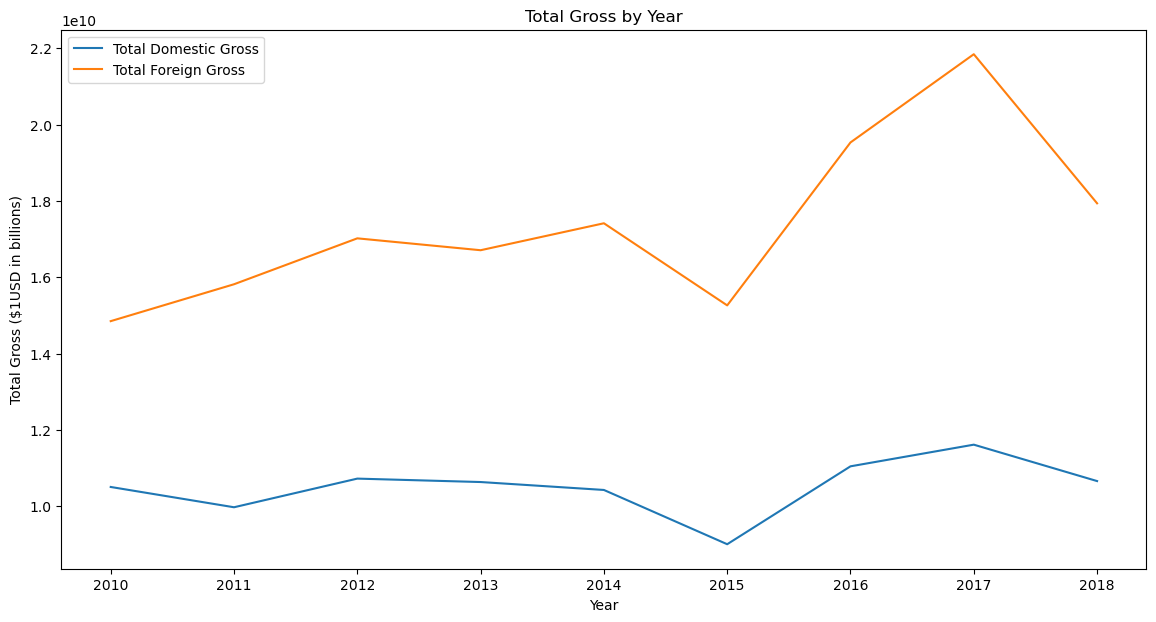

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

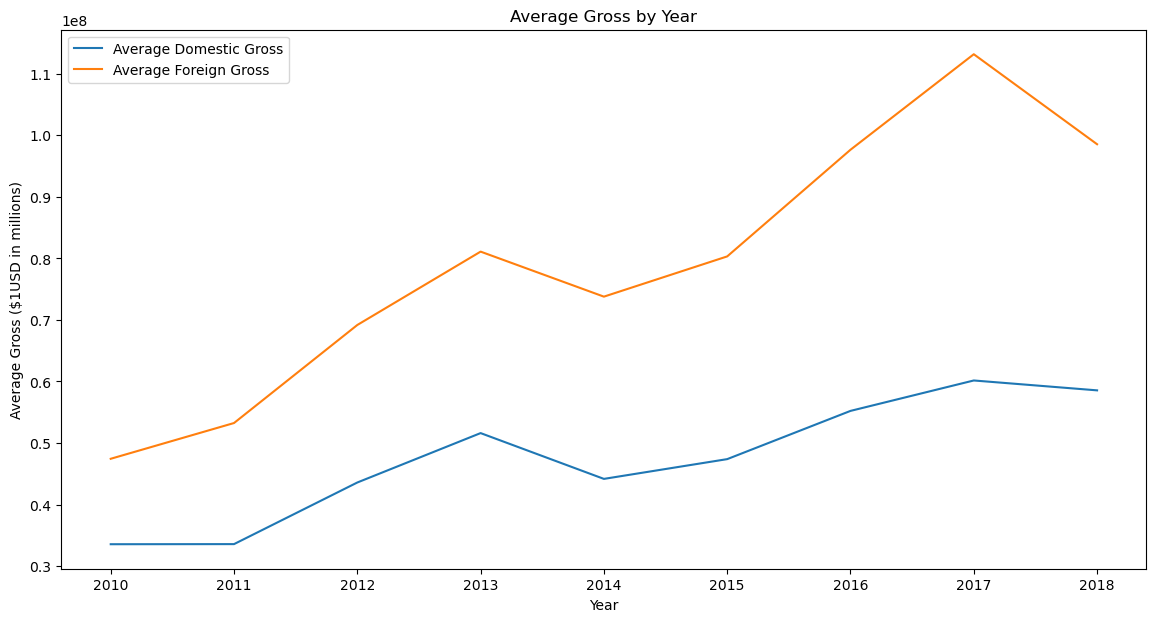

In [60]:
# Plot total and average gross by year
plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='total_domestic_gross', label='Total Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='total_foreign_gross', label='Total Foreign Gross')
plt.title('Total Gross by Year')
plt.xlabel('Year')
plt.ylabel('Total Gross ($1USD in billions)')
plt.legend()
plt.savefig('Total_gross_by_year')
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='average_domestic_gross', label='Average Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='average_foreign_gross', label='Average Foreign Gross')
plt.title('Average Gross by Year')
plt.xlabel('Year')
plt.ylabel('Average Gross ($1USD in millions)')
plt.legend()

plt.savefig('Total_avg_by_year')
plt.show()



## Barplot for Top Genres

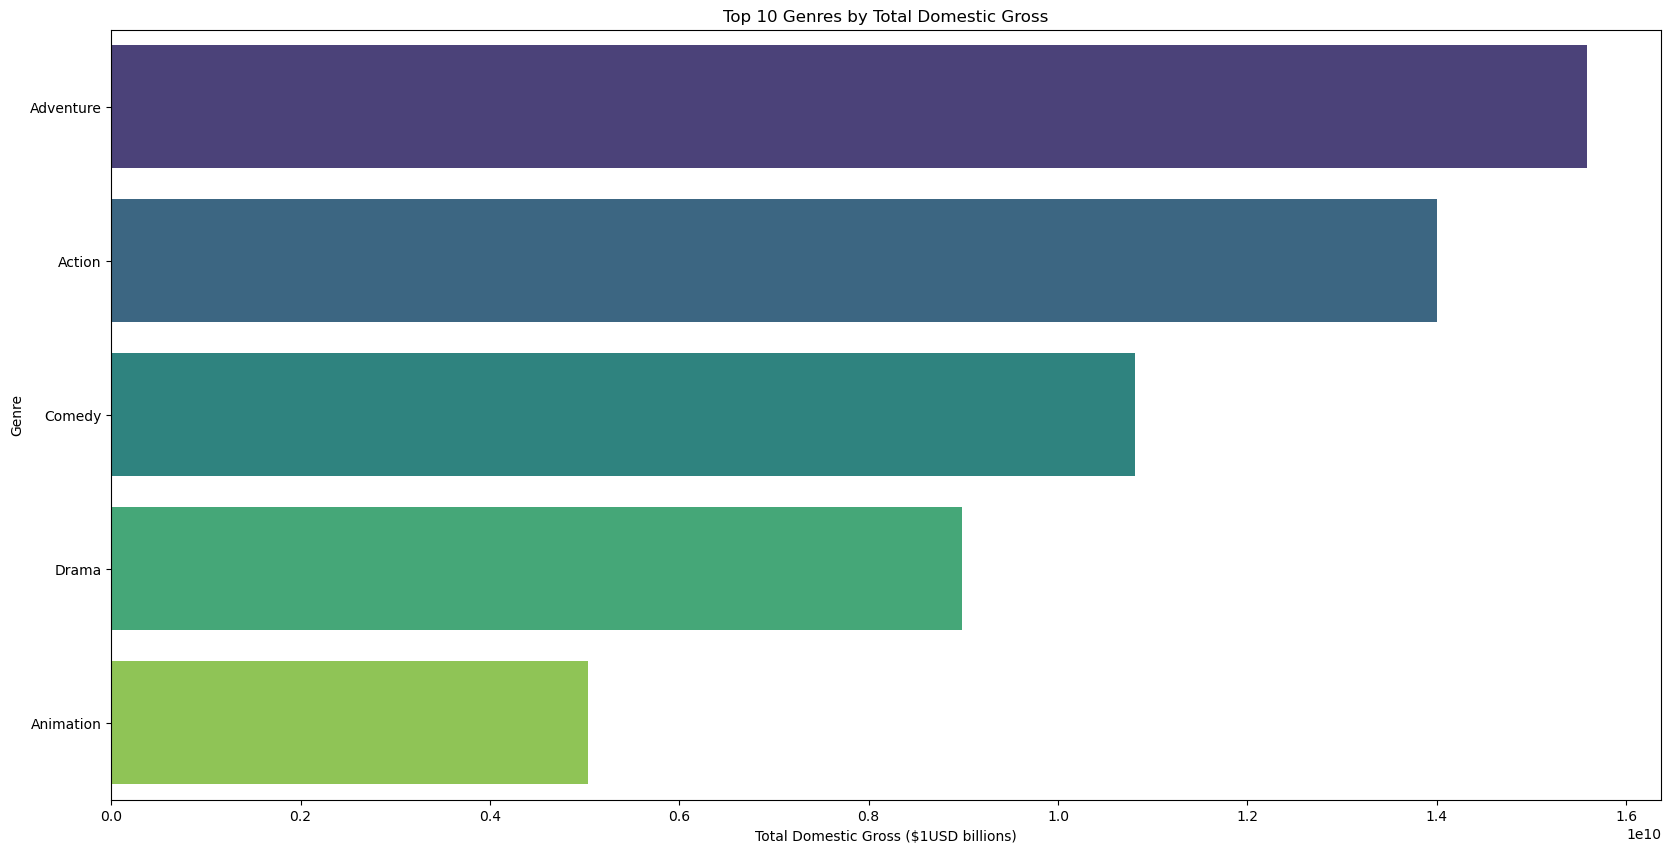

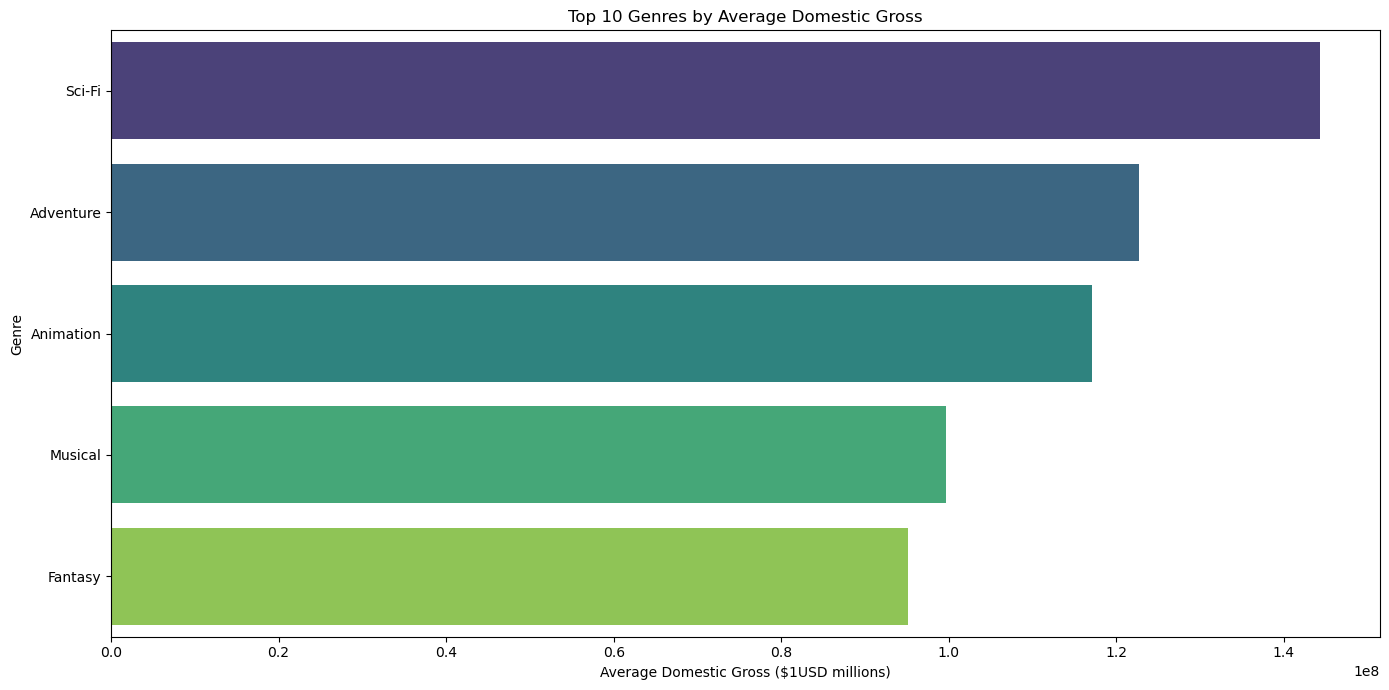

In [61]:
# Plot total and average gross by genre
plt.figure(figsize=(20, 10))
sns.barplot(data=gross_by_genre.sort_values(by='total_domestic_gross', ascending=False).head(),
            x='total_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Total Domestic Gross')
plt.xlabel('Total Domestic Gross ($1USD billions)')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_domestic_gross')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(data=gross_by_genre.sort_values(by='average_domestic_gross', ascending=False).head(),
            x='average_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Average Domestic Gross')
plt.xlabel('Average Domestic Gross ($1USD millions)')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('Top_10_Genres_by__avg_domestic_gross')
plt.show()

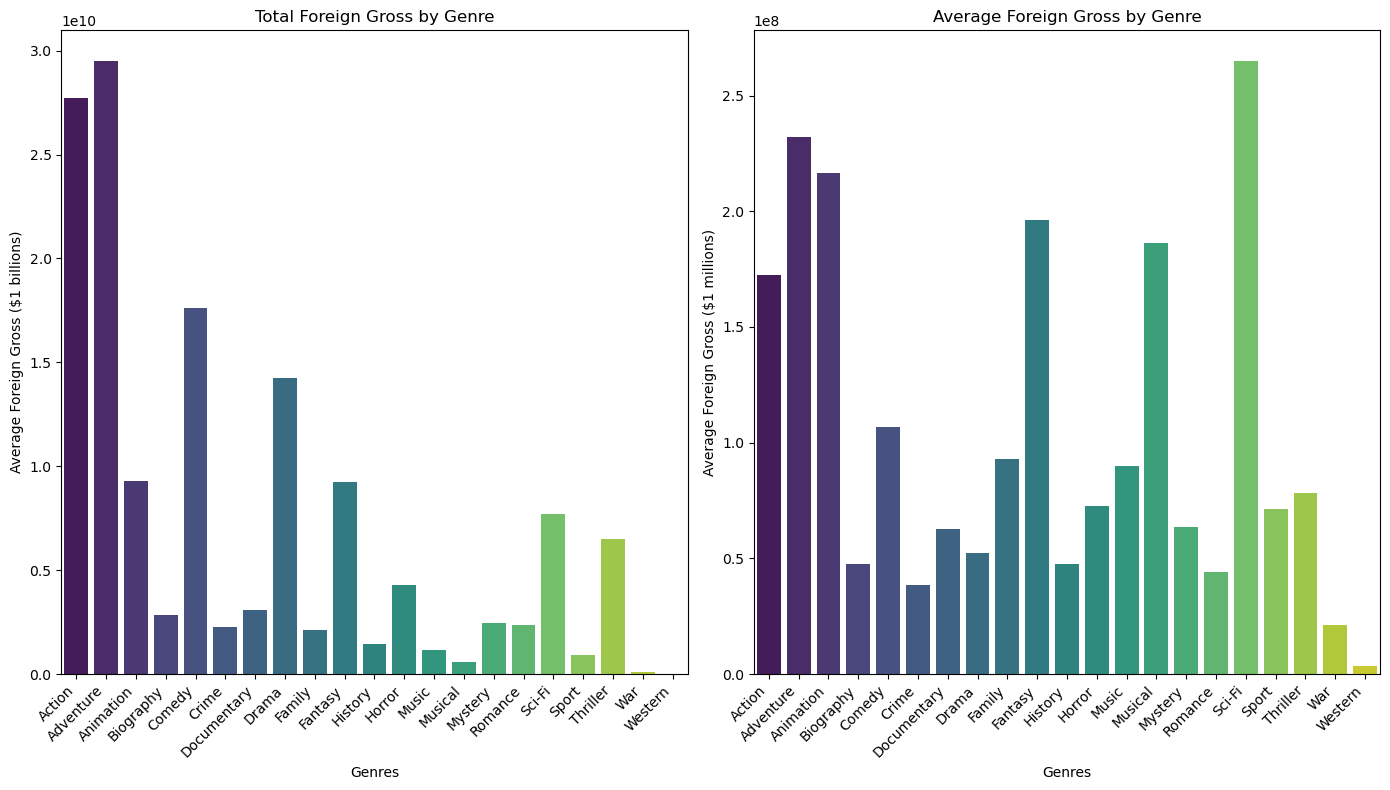

In [62]:
# Bar plot for average domestic and foreign gross by genre
plt.figure(figsize=(14, 8))

# Plot average domestic gross

plt.subplot(1, 2, 1)
sns.barplot(data=gross_by_genre, x='genres', y='total_foreign_gross', palette='viridis')
plt.title('Total Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross ($1 billions)')
plt.xticks(rotation=45, ha='right')


# Plot average foreign gross
plt.subplot(1, 2, 2)
sns.barplot(data=gross_by_genre, x='genres', y='average_foreign_gross', palette='viridis')
plt.title('Average Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross ($1 millions)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Total_foreign_and_average_gross_by_genre')
plt.show()

In [63]:
synopsis_df.describe()

,id,box_office,production_budget,domestic_gross,worldwide_gross
count,5782.000000,1.099000e+03,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.365105e+07,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.437094e+07,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.349040e+05,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,6.000000e+05,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.070679e+07,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,5.410000e+07,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,1.320889e+08,4.250000e+08,9.366622e+08,2.776345e+09


### Hypothesis testing for production budget and gross revenue

####  Null Hypothesis: 
There is no relation between a high production budget and the gross revenue

#### Alternative Hypothesis: 
The higher the production budget the higher the revenue for the film.

PRODUCTION MEAN: 31587757.0965064
PRODUCTION MEDIAN: 17000000.0
PRODUCTION MODE: 0    20000000.0
Name: production_budget, dtype: float64
PRODUCTION STANDARD DEVIATION: 41812076.82694316

DOMESTIC GROSS MEAN: 41873326.867001034
DOMESTIC GROSS MEDIAN: 17225945.0
DOMESTIC GROSS MODE: 0    0.0
Name: domestic_gross, dtype: float64
DOMESTIC GROSS STANDARD DEVIATION: 68240597.35690318

WORLDWIDE GROSS MEAN: 91487460.90643376
WORLDWIDE GROSS MEDIAN: 27984448.5
WORLDWIDE GROSS MODE: 0    0.0
Name: worldwide_gross, dtype: float64
WORLDWIDE GROSS STANDARD DEVIATION: 174719968.77890623



C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


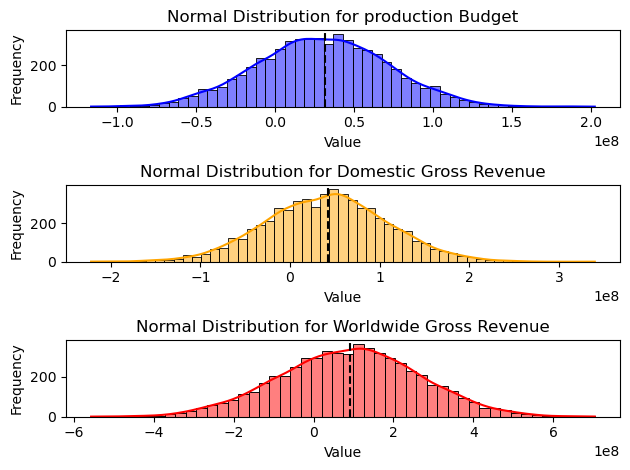

In [65]:
#Normalize the data from production budget, domestic gross, ww gross
np.random.seed(3)

prod_mean = synopsis_df['production_budget'].mean()
prod_median = synopsis_df['production_budget'].median()
prod_mode = synopsis_df['production_budget'].mode()
prod_std = synopsis_df['production_budget'].std()

print(f'PRODUCTION MEAN: {prod_mean}')
print(f'PRODUCTION MEDIAN: {prod_median}')
print(f'PRODUCTION MODE: {prod_mode}')
print(f'PRODUCTION STANDARD DEVIATION: {prod_std}')
print()


prod_data = np.random.normal(loc= prod_mean, scale=prod_std, size = len(synopsis_df['production_budget']))


dom_mean = synopsis_df['domestic_gross'].mean()
dom_median = synopsis_df['domestic_gross'].median()
dom_mode = synopsis_df['domestic_gross'].mode()
dom_std = synopsis_df['domestic_gross'].std()

print(f'DOMESTIC GROSS MEAN: {dom_mean}')
print(f'DOMESTIC GROSS MEDIAN: {dom_median}')
print(f'DOMESTIC GROSS MODE: {dom_mode}')
print(f'DOMESTIC GROSS STANDARD DEVIATION: {dom_std}')
print()


domestic_data = np.random.normal(loc=dom_mean, scale=dom_std, size=len(synopsis_df['domestic_gross'])) 


ww_mean = synopsis_df['worldwide_gross'].mean()
ww_median = synopsis_df['worldwide_gross'].median()
ww_mode = synopsis_df['worldwide_gross'].mode()
ww_std = synopsis_df['worldwide_gross'].std()

print(f'WORLDWIDE GROSS MEAN: {ww_mean}')
print(f'WORLDWIDE GROSS MEDIAN: {ww_median}')
print(f'WORLDWIDE GROSS MODE: {ww_mode}')
print(f'WORLDWIDE GROSS STANDARD DEVIATION: {ww_std}')
print()

ww_data = np.random.normal(loc=ww_mean, scale=ww_std, size=len(synopsis_df['worldwide_gross']))

# Create a figure and a set of subplots
# fig, ax = plt.subplots(3, 1, figsize=(12, 6))

plt.subplot(3,1,1)
sns.histplot(prod_data,color='blue', kde=True)
plt.title("Normal Distribution for production Budget")
plt.axvline(x= prod_mean, linestyle='--', color='black')
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(3,1,2)
sns.histplot(domestic_data, color='orange',kde=True)
plt.axvline(x= dom_mean, linestyle='--', color='black')
plt.title("Normal Distribution for Domestic Gross Revenue")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(3,1,3)
sns.histplot(ww_data, color='r', kde=True)
plt.axvline(x= ww_mean, linestyle='--', color='black')
plt.title("Normal Distribution for Worldwide Gross Revenue")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


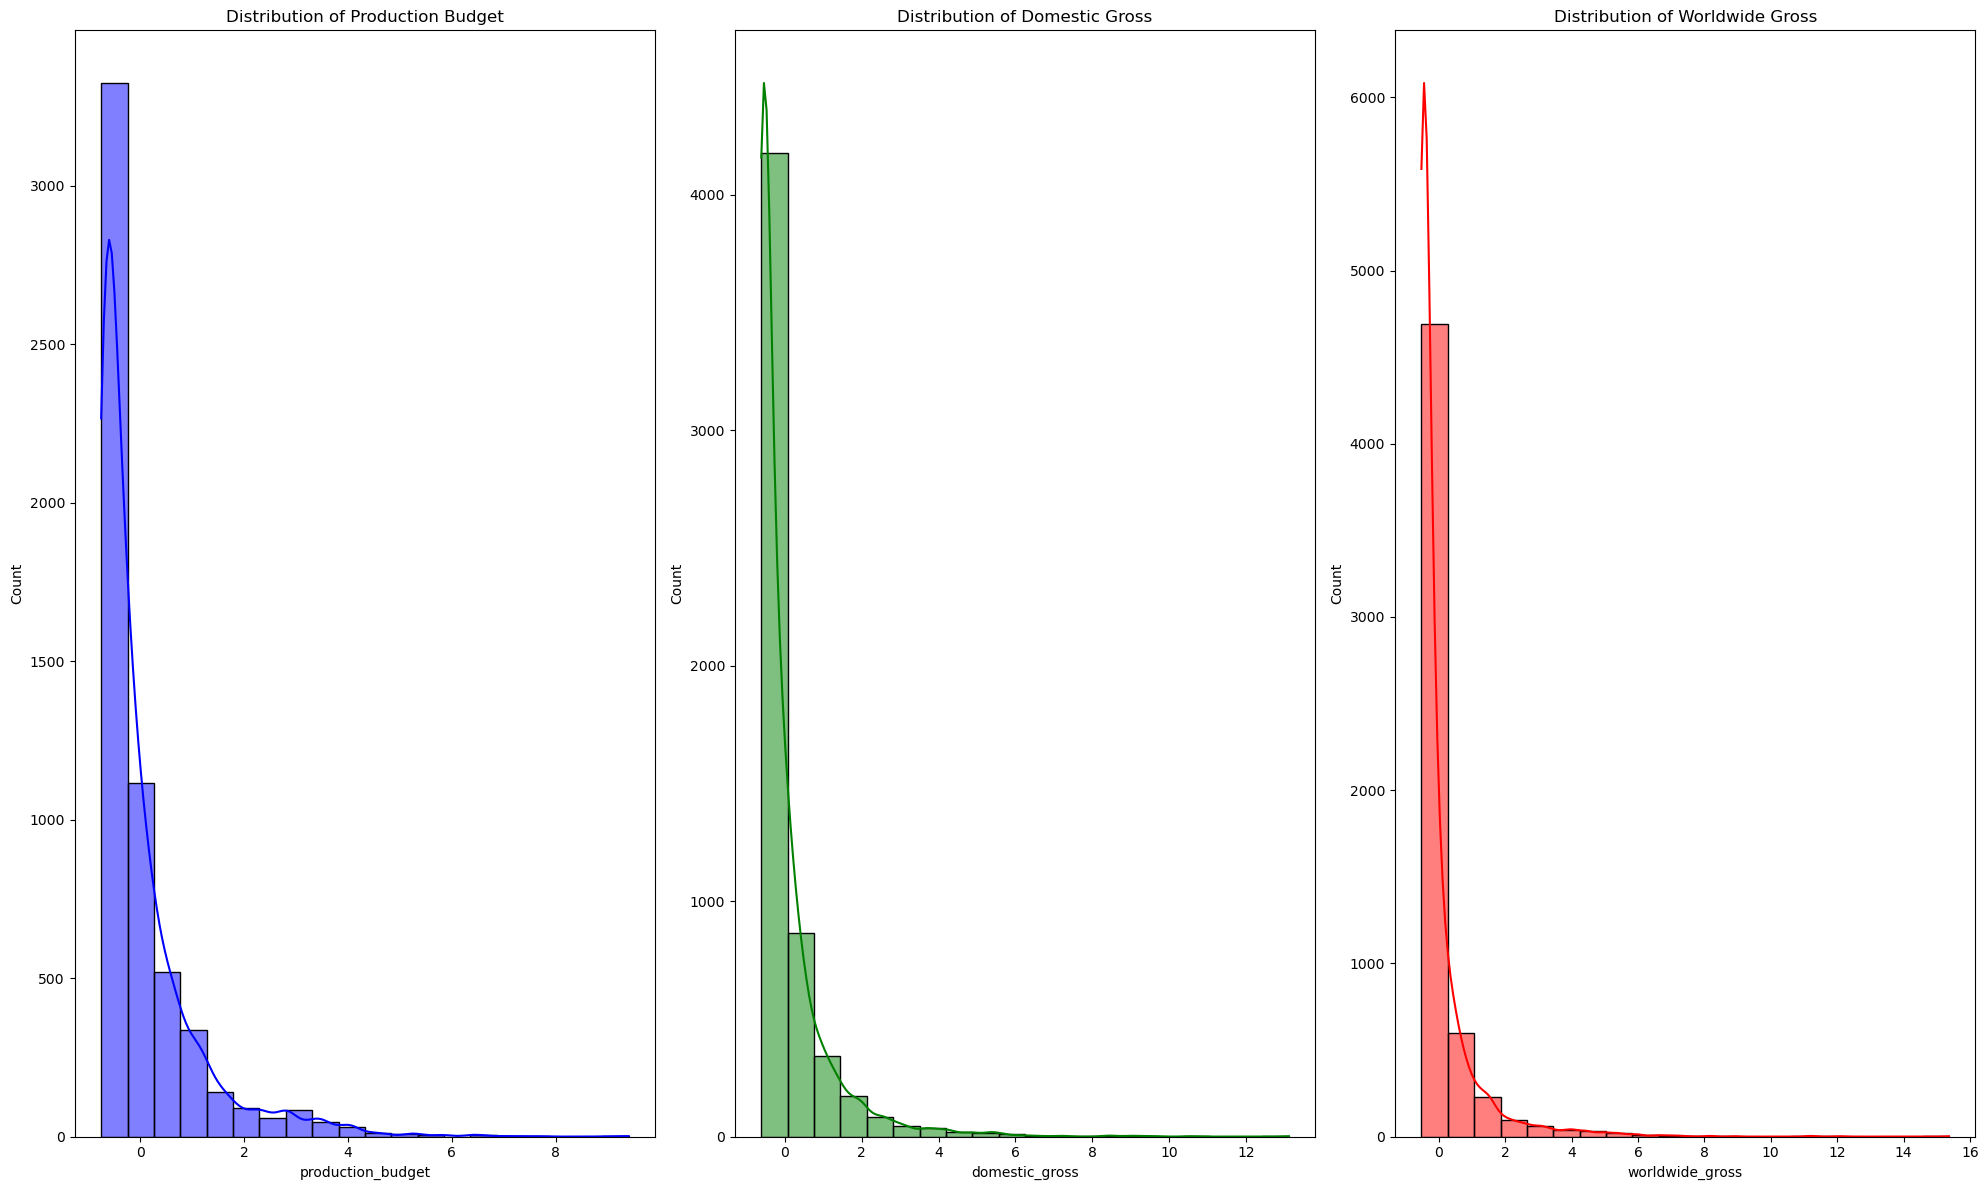

In [70]:
# #Standardized the data 
# prod_z_score = stats.zscore(synopsis_df['production_budget'])
# dom_z_score = stats.zscore(synopsis_df['domestic_gross'])
# ww_z_score  =stats.zscore(synopsis_df['worldwide_gross'])
import scipy.stats
# Standardize data (z-scores)
prod_z_scores = scipy.stats.zscore(synopsis_df['production_budget'])
dom_z_score = scipy.stats.zscore(synopsis_df['domestic_gross'])
ww_z_score = scipy.stats.zscore(synopsis_df['worldwide_gross'])


#Hustogram for Production Budget, Domestic Gross, and Worldwide Gross
fig, axes = plt.subplots(1,3, figsize=(20,12))

sns.histplot(prod_z_scores, bins=20, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Production Budget')


sns.histplot(dom_z_score, bins=20, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Domestic Gross')


sns.histplot(ww_z_score, bins=20, kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribution of Worldwide Gross')

plt.tight_layout()
plt.savefig('Distributions')
plt.show()

In [71]:
#Cofidence level for production budgets
std_err = np.std(synopsis_df['production_budget'], ddof=1) / np.sqrt(len(synopsis_df['production_budget']))

confidence_level = 0.95
z_value = scipy.stats.norm.ppf((1 + confidence_level) / 2)
margin_of_err = std_err * z_value

# Confidence interval
confidence_interval = (prod_mean - margin_of_err, prod_mean + margin_of_err)
print(f'Product 95% Confidence level: {confidence_interval}')

Product 95% Confidence level: (30510025.07429116, 32665489.118721638)


In [76]:
#production budget Z-TEST

prod_sample_data = np.random.choice(synopsis_df['production_budget'], size=100, replace=False)
prod_sample_mean = np.mean(prod_sample_data)
prod_sample_std = np.std(prod_sample_data, ddof=1)
n = len(prod_sample_data)

prod_z_score = (prod_sample_mean - prod_mean) / (prod_sample_std / np.sqrt(n))

prod_p_value = scipy.stats.norm.sf(abs(prod_z_score))

print(f'Product Z Score: {prod_z_score}, Product P-Value: {prod_p_value}')

dom_sample_data = np.random.choice(synopsis_df['domestic_gross'], size=100, replace=False)
dom_sample_mean = np.mean(dom_sample_data)
dom_sample_std = np.std(dom_sample_data, ddof=1)
n = len(dom_sample_data)

dom_z_score = (dom_sample_mean - dom_mean) / (dom_sample_std / np.sqrt(n))

dom_p_value = scipy.stats.norm.sf(abs(dom_z_score))

print(f'Domestic Z-score: {dom_z_score}, Domestic P-Value: {dom_p_value}')

ww_sample_data = np.random.choice(synopsis_df['worldwide_gross'], size=100, replace=False)
ww_sample_mean = np.mean(ww_sample_data)
ww_sample_std = np.std(ww_sample_data, ddof=1)
n = len(ww_sample_data)

ww_z_score = (ww_sample_mean - ww_mean) / (ww_sample_std / np.sqrt(n))

ww_p_value = scipy.stats.norm.sf(abs(ww_z_score))

print(f'WW Z-score: {ww_z_score}, WW P-Value: {ww_p_value}')

Product Z Score: 0.7626221468909986, Product P-Value: 0.2228443863447177
Domestic Z-score: -2.846000027601304, Domestic P-Value: 0.0022136095521039754
WW Z-score: -0.5062034472092606, WW P-Value: 0.30635691764429224


#### Distribution Plot: Production Budget

    Purpose: This plot displays the overall distribution of production budgets across all movies.
    
    Interpretation:
        Peak of the Distribution: Shows where most production budgets lie, whether it's in the lower, middle, or higher range.
        KDE Line (Kernel Density Estimation): The smooth curve over the histogram shows the estimated probability density function, providing a visual understanding of the budget distribution.
        Skewness: If the distribution is skewed to the right, it indicates that while most movies have relatively lower budgets, a few movies have very high budgets.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


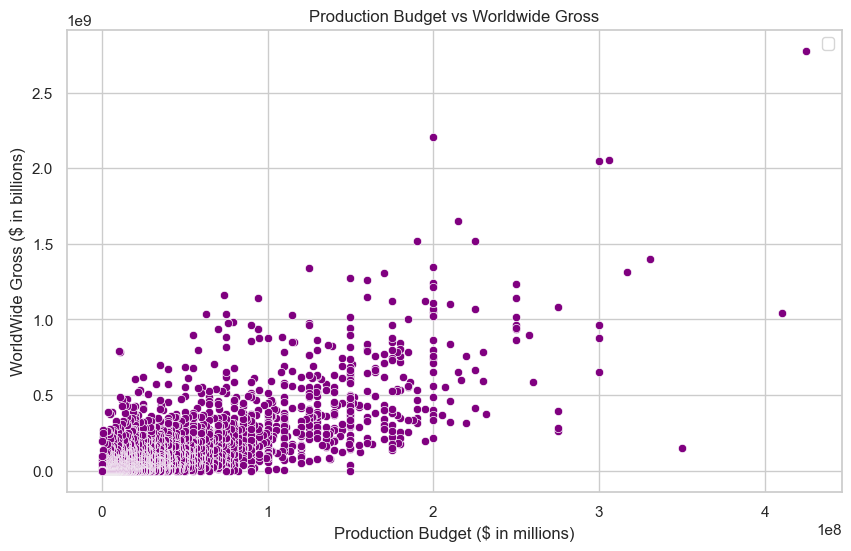

In [77]:
#set style for plots
sns.set(style='whitegrid')



# # Box Plot for Production Budget, Domestic Gross, and Worldwide Gross
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# sns.boxplot(y=synopsis_df['production_budget'], ax=axes[0], color='blue')
# axes[0].set_title('Box Plot of Production Budget')
# plt.yscale('log')

# sns.boxplot(y=synopsis_df['domestic_gross'], ax=axes[1], color='green')
# axes[1].set_title('Box Plot of Domestic Gross')
# plt.yscale('log')

# sns.boxplot(y=synopsis_df['worldwide_gross'], ax=axes[2], color='red')
# axes[2].set_title('Box Plot of Worldwide Gross')

# plt.tight_layout()
# plt.yscale('log')
# plt.savefig('Boxplots')
# plt.show()

# Scatter Plot for Production Budget vs Gross
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=synopsis_df['production_budget'], y=synopsis_df['worldwide_gross'], ax=ax, color='purple')
ax.set_title('Production Budget vs Worldwide Gross')
ax.set_xlabel('Production Budget ($ in millions)')
ax.set_ylabel('WorldWide Gross ($ in billions)')
plt.legend()
plt.savefig('Scatterplot production vs gross')
plt.show()

#### Scatter Plot: Production Budget vs. Worldwide Gross

    Purpose: This plot helps visualize the relationship between a movie's production budget and its worldwide gross revenue.
    
    Interpretation:
        Positive correlation: If most points trend upwards from left to right, it suggests that movies with higher production budgets tend to earn more worldwide.
        Outliers: Points that deviate significantly from the trend line (e.g., high budget with low gross or low budget with high gross) indicate movies that either overperformed or underperformed relative to their budgets.


#### Production budget by Genre

Purpose: This plot shows how production budgets vary across different movie genres.
Interpretation:

    Genre Comparison: The plot allows for a comparison of budgets across genres. For instance, genres like "Action" or "Adventure" might show higher budgets on average compared to genres like "Drama" or "Comedy."
    Logarithmic Scale: A log scale on the y-axis helps visualize data that spans multiple orders of magnitude, making it easier to compare genres with vastly different budget ranges.
    Outliers: Movies within a genre that have exceptionally high or low budgets relative to others in the same genre will appear as individual points outside the whiskers.

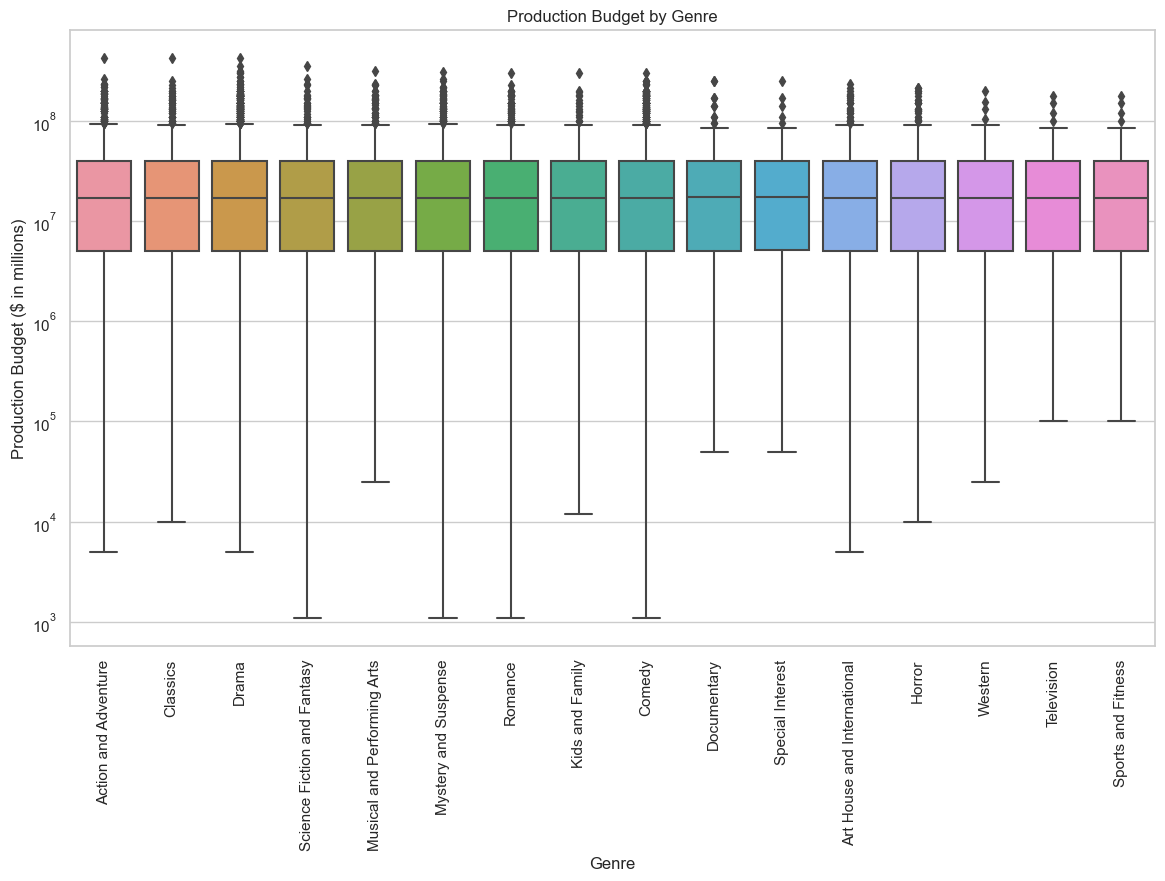

In [78]:
plt.figure(figsize=(14,8))
sns.boxplot(data=merged_genres, x='genre', y='production_budget')
plt.title('Production Budget by Genre')
plt.xlabel('Genre')
plt.ylabel('Production Budget ($ in millions)')
plt.xticks(rotation=90)
plt.yscale('log') #use log scale to handle wide rane of budgets
plt.savefig('production Budget by Genre')
plt.show()

#### Heatmap: Correlation Between Numeric Variables

This heatmap visualizes the correlation between key numerical variables such as production budget, domestic gross, and worldwide gross.
Interpretation:

    Correlation Coefficients: Values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values around 0 indicate no correlation.
    Color Gradient: The heatmap uses a color gradient to represent the strength of the correlations. Darker or more intense colors indicate stronger correlations.
    Insights: For example, a strong positive correlation between production budget and worldwide gross would suggest that higher-budget movies generally earn more worldwide.

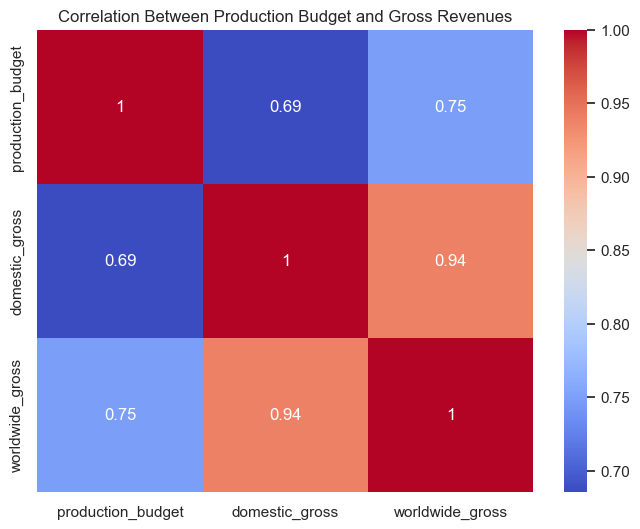

In [79]:
plt.figure(figsize=(8, 6))
sns.heatmap(synopsis_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Production Budget and Gross Revenues')
plt.savefig('Correlation between Production Budget and Gross Revenues')
plt.show()

#### Group the Data by Directors

To understand the relationship between directors and the budgets/gross values, it might be useful to aggregate the data by directors.

In [81]:
# Group by directors and calculate mean of the budgets and gross per director
director_grouped = synopsis_df.groupby('director').agg({
    'production_budget': 'mean',
    'domestic_gross': 'mean',
    'worldwide_gross': 'mean'
}).reset_index()

# Display the aggregated DataFrame
director_grouped.head(10)

,director,production_budget,domestic_gross,worldwide_gross
0,Alan Alda,3.027216e+07,4.214399e+07,8.887686e+07
1,Alan Hale,2.995821e+07,3.844114e+07,8.587932e+07
2,Allen Hughes|Albert Hughes,3.083160e+07,4.798312e+07,1.139748e+08
3,Allison Anders,3.472362e+07,4.948760e+07,1.054566e+08
4,Anatole Litvak,3.034490e+07,5.054890e+07,1.164315e+08
5,Andy Sidaris,3.112586e+07,4.185722e+07,9.233709e+07
6,Barry Levinson,3.449806e+07,5.244219e+07,1.125342e+08
7,Ben Younger,3.010175e+07,3.571045e+07,7.324444e+07
8,Bill Froehlich,3.071319e+07,5.012949e+07,1.112841e+08
9,Bruce Beresford,3.023153e+07,4.036557e+07,7.016328e+07


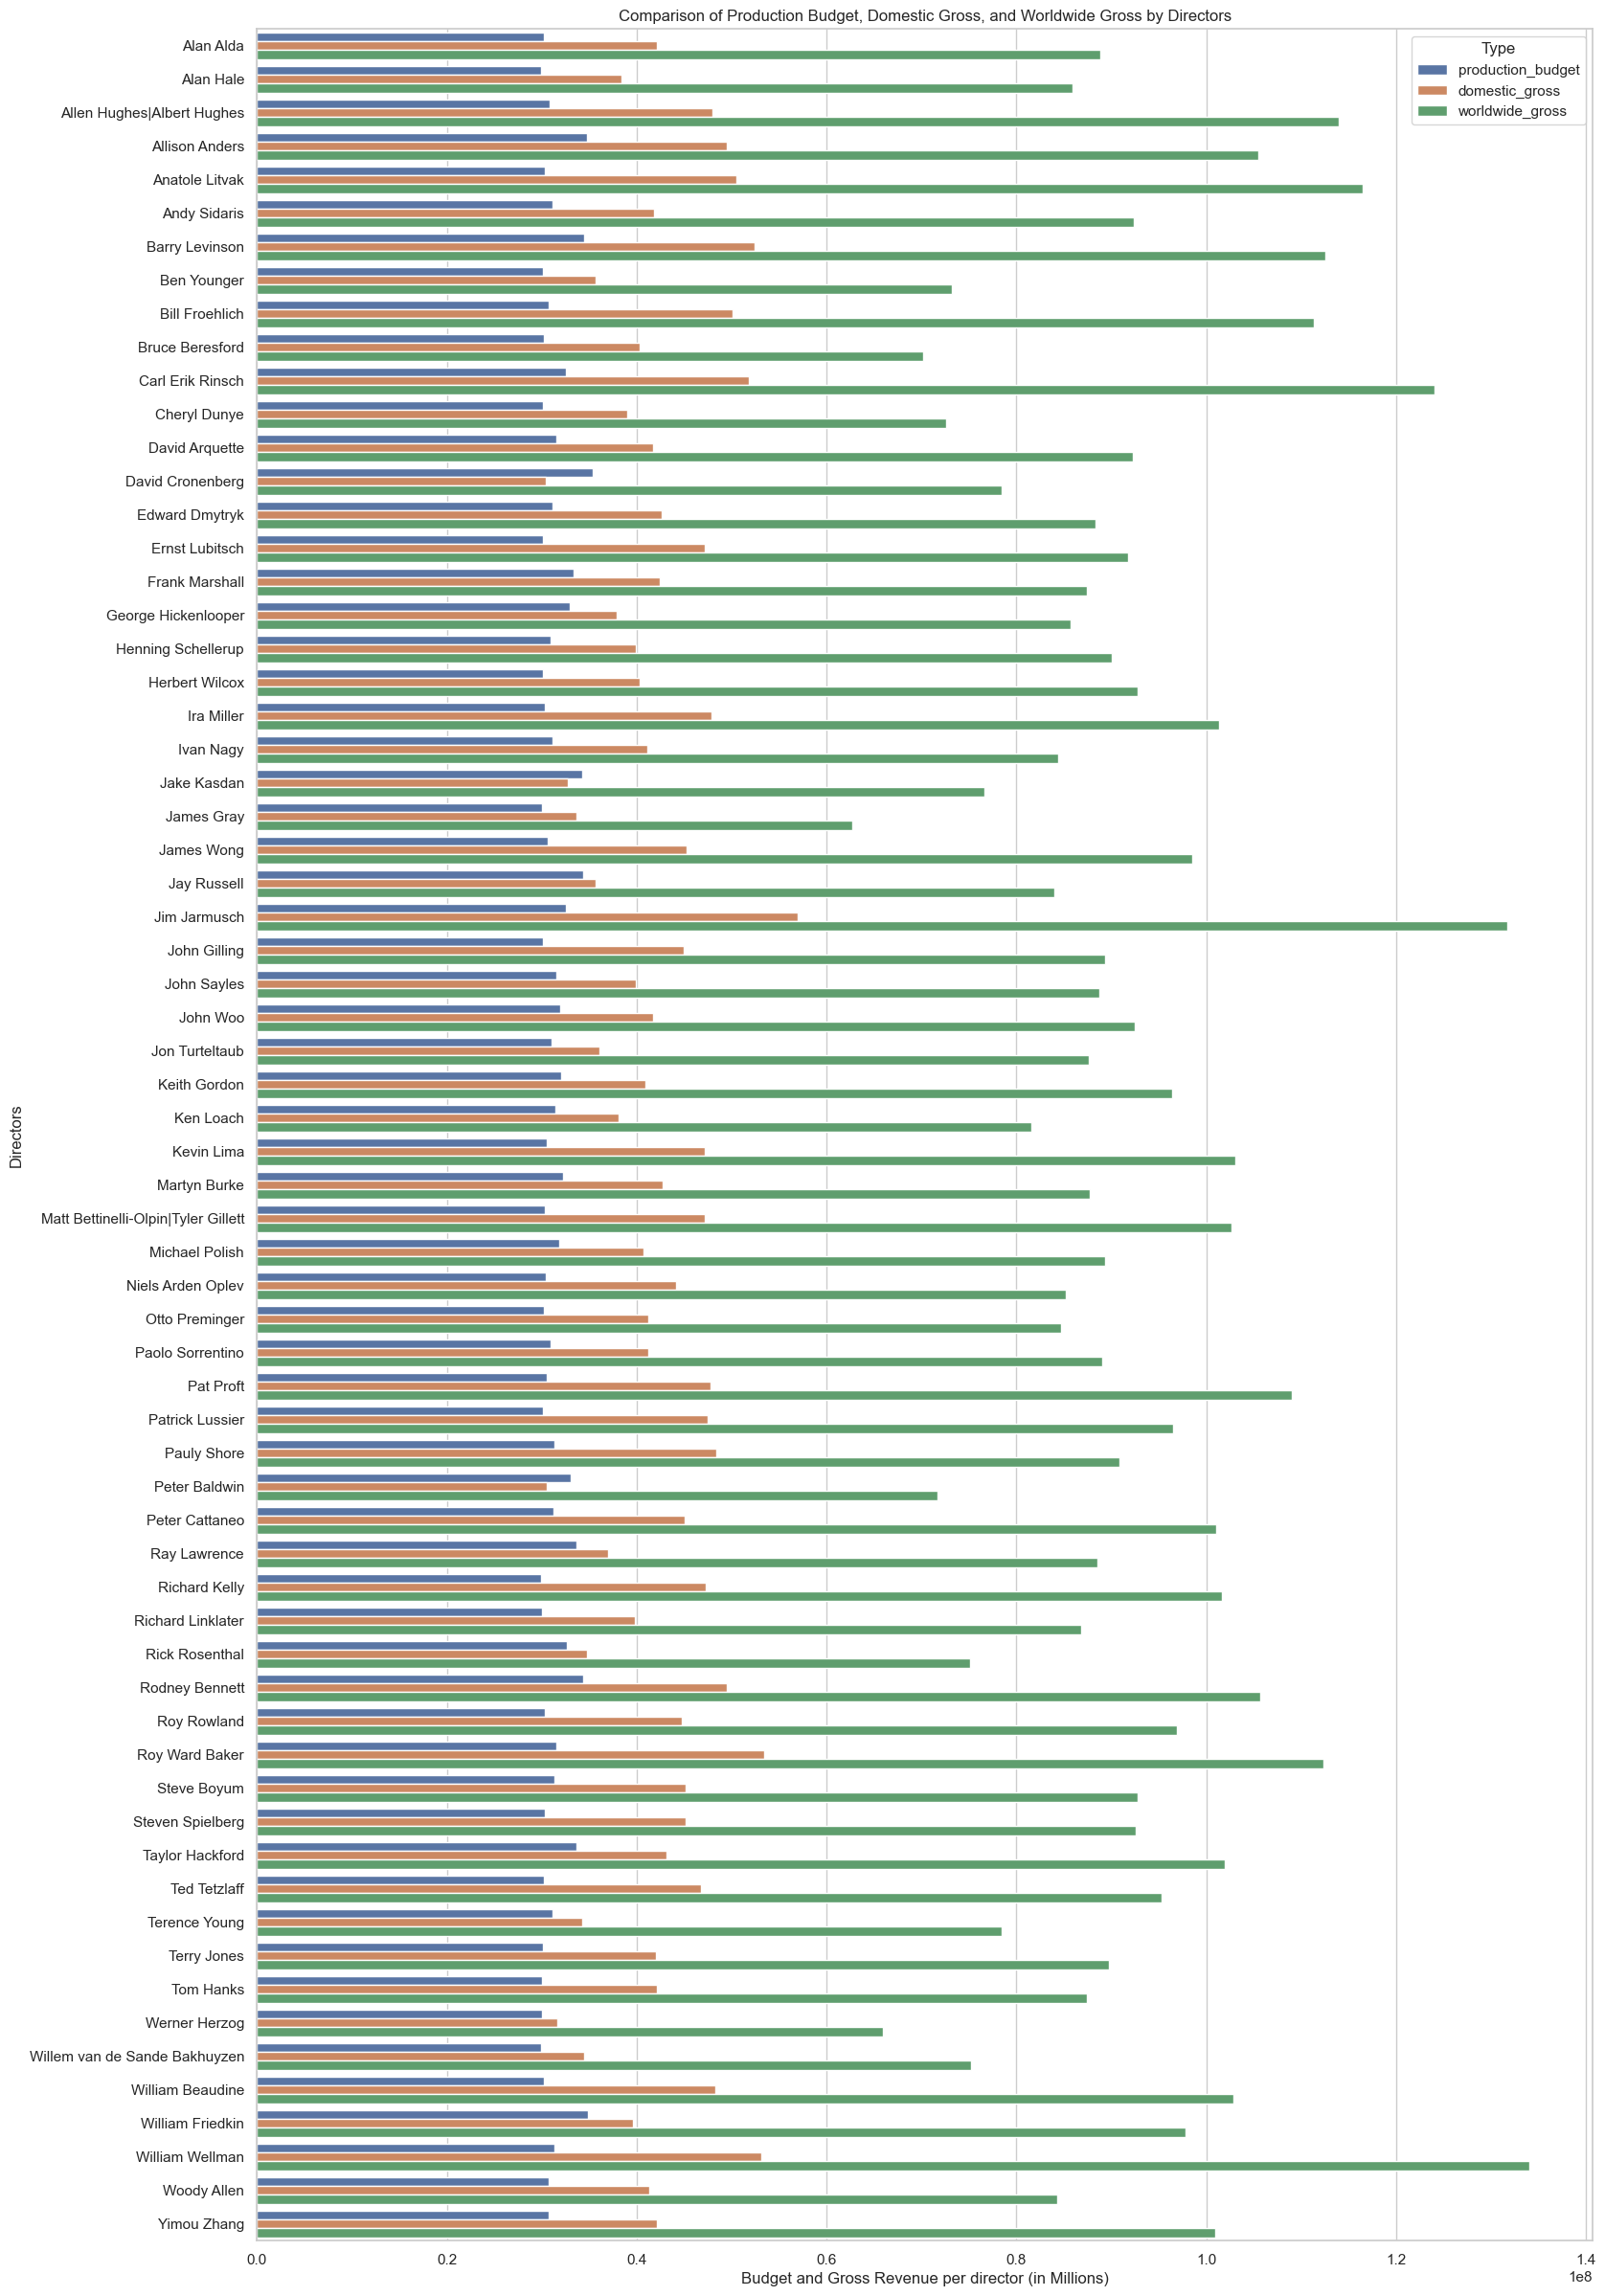

In [82]:
# Set the plot size
plt.figure(figsize=(18, 30))

# Melt the DataFrame for easier plotting
melted_df = pd.melt(director_grouped, id_vars='director', value_vars=['production_budget', 'domestic_gross', 'worldwide_gross'], var_name='Type', value_name='Amount')
# Create a bar plot
sns.barplot(x='Amount', y='director', hue='Type', data=melted_df)

# Add labels and title
plt.xlabel('Budget and Gross Revenue per director (in Millions)')
plt.ylabel('Directors')
plt.title('Comparison of Production Budget, Domestic Gross, and Worldwide Gross by Directors')
plt.legend(title='Type')
plt.savefig('Budget and Gross based on Director')
plt.show()

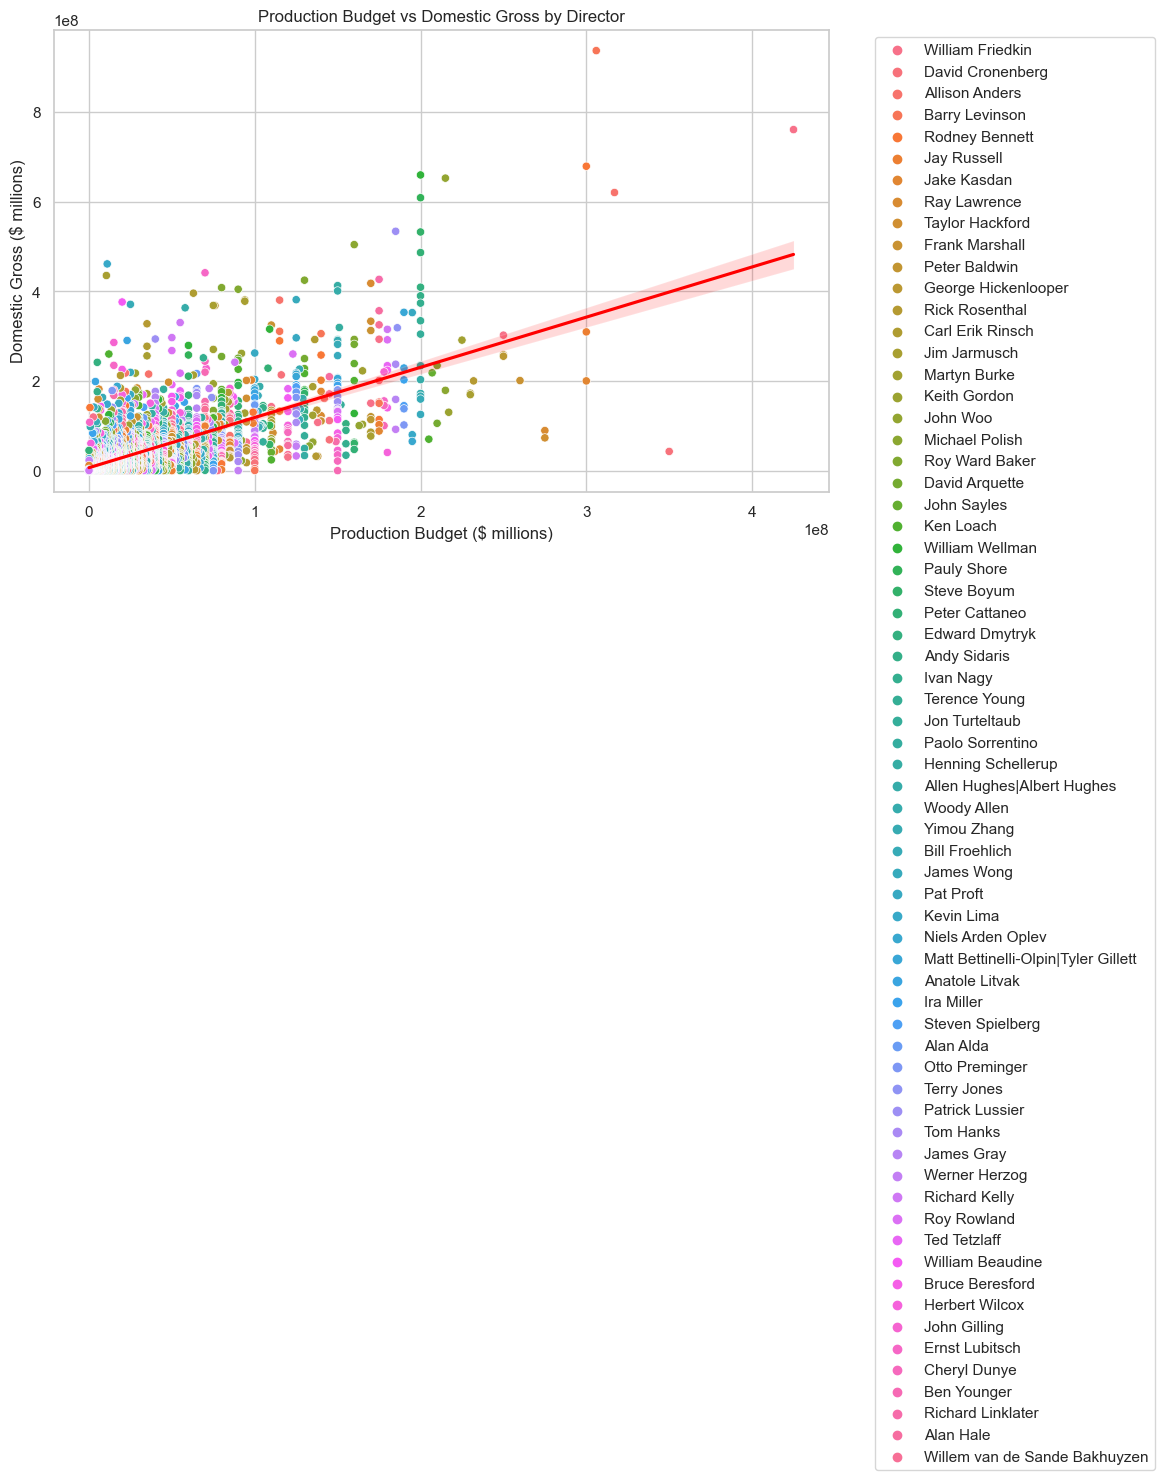

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='domestic_gross', hue='director', data=synopsis_df)
# Add the regression line (without hue distinction)
sns.regplot(x='production_budget', y='domestic_gross', data=synopsis_df, scatter=False, color='red', line_kws={"label": "Linear Regression"})
plt.xlabel('Production Budget ($ millions)')
plt.ylabel('Domestic Gross ($ millions)')
plt.title('Production Budget vs Domestic Gross by Director')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as a PNG file
plt.savefig('production_vs_domestic.png', bbox_inches='tight')
plt.show()

In [84]:
save_df_to_directory(melted_df, './accessible_data/', 'melted_df.csv')

In [85]:
# Calculate mean and confidence intervals for each genre
gross_grouped = gross_by_genre.groupby('genres').agg(
    mean_domestic_gross=('total_domestic_gross', 'mean'),
    mean_foreign_gross=('total_foreign_gross', 'mean'),
).reset_index()
gross_grouped

,genres,mean_domestic_gross,mean_foreign_gross
0,Action,1.399706e+10,2.774456e+10
1,Adventure,1.558946e+10,2.950450e+10
2,Animation,5.035712e+09,9.304000e+09
3,Biography,1.866453e+09,2.840872e+09
4,Comedy,1.081684e+10,1.762384e+10
5,Crime,2.041605e+09,2.273621e+09
6,Documentary,2.114256e+09,3.065777e+09
7,Drama,8.987940e+09,1.423651e+10
8,Family,1.305268e+09,2.134300e+09
9,Fantasy,4.473551e+09,9.217900e+09


In [86]:
save_df_to_directory(gross_grouped, './accessible_data/', 'gross_grouped.csv')

In [107]:
#merge movie_ratings_df and movies_basics_df
merged_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id')
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [108]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [109]:
merged_df['runtime_minutes'].fillna(merged_df['runtime_minutes'].mean(), inplace=True)

In [110]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  73856 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [111]:
save_df_to_directory(merged_df, './accessible_data/', 'movie_ratings_and_basics.csv')

In [112]:
merged_df.describe()


,start_year,runtime_minutes,averagerating,numvotes
count,73856.000000,73856.00000,73856.000000,7.385600e+04
mean,2014.276132,94.65404,6.332729,3.523662e+03
std,2.614807,197.52143,1.474978,3.029402e+04
min,2010.000000,3.00000,1.000000,5.000000e+00
25%,2012.000000,83.00000,5.500000,1.400000e+01
50%,2014.000000,93.00000,6.500000,4.900000e+01
75%,2016.000000,101.00000,7.400000,2.820000e+02
max,2019.000000,51420.00000,10.000000,1.841066e+06


In [113]:
# Calculate measures of central tendency and measurements of dispersion
mean_rating = merged_df['averagerating'].mean()
median_rating = merged_df['averagerating'].median()
mode_rating = merged_df['averagerating'].mode()[0]

std_dev_rating = merged_df['averagerating'].std()
variance_rating = merged_df['averagerating'].var()

mean_votes = merged_df['numvotes'].mean()
median_votes = merged_df['numvotes'].median()
mode_votes = merged_df['numvotes'].mode()[0]

std_dev_votes =merged_df['numvotes'].std()
variance_votes = merged_df['numvotes'].var()

print(f"Mean Rating: {mean_rating}")
print(f"Median Rating: {median_rating}")
print(f"Mode Rating: {mode_rating}")
print(f"Standard Deviation of Ratings: {std_dev_rating}")
print(f"Variance of Ratings: {variance_rating}")

print(f"Mean Votes: {mean_votes}")
print(f"Median Votes: {median_votes}")
print(f"Mode Votes: {mode_votes}")
print(f"Standard Deviation of Votes: {std_dev_votes}")
print(f"Variance of Votes: {variance_votes}")

Mean Rating: 6.332728552859619
Median Rating: 6.5
Mode Rating: 7.0
Standard Deviation of Ratings: 1.4749783548957582
Variance of Ratings: 2.1755611474109973
Mean Votes: 3523.6621669194105
Median Votes: 49.0
Mode Votes: 6
Standard Deviation of Votes: 30294.022971103946
Variance of Votes: 917727827.7737737


In [114]:
# Split the genres column
merged_df.loc[merged_df.index, 'genres'] = merged_df['genres'].str.split(',')

# Explode the genres column
exploded_df = merged_df.explode('genres')
exploded_df


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Action,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Crime,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Drama,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Biography,7.2,43
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Drama,7.2,43
...,...,...,...,...,...,...,...,...
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Drama,8.7,136
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Family,8.7,136
73853,tt9914642,Albatross,Albatross,2017,94.65404,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,94.65404,None,6.6,5


In [115]:
exploded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129294 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         129294 non-null  object 
 1   primary_title    129294 non-null  object 
 2   original_title   129294 non-null  object 
 3   start_year       129294 non-null  int64  
 4   runtime_minutes  129294 non-null  float64
 5   genres           128490 non-null  object 
 6   averagerating    129294 non-null  float64
 7   numvotes         129294 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 8.9+ MB


In [116]:
# Reset the index to avoid issues with duplicate labels
exploded_df.reset_index(drop=True, inplace=True)

# Remove outliers from 'average_rating' and 'num_votes' using Z-score
exploded_df['zscore_rating'] = zscore(exploded_df['averagerating'])
exploded_df['zscore_votes'] = zscore(exploded_df['numvotes'])

# Filter out the outliers
df_cleaned = exploded_df[(exploded_df['zscore_rating'].abs() <= 3) & (exploded_df['zscore_votes'].abs() <= 3)]

# Drop the Z-score columns as they are no longer needed
df_cleaned.drop(columns=['zscore_rating', 'zscore_votes'], inplace=True)
exploded_df

C:\Users\omend\AppData\Local\Temp\ipykernel_53724\2703187828.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['zscore_rating', 'zscore_votes'], inplace=True)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,zscore_rating,zscore_votes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Action,7.0,77,0.477801,-0.137670
1,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Crime,7.0,77,0.477801,-0.137670
2,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Drama,7.0,77,0.477801,-0.137670
3,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Biography,7.2,43,0.614973,-0.138565
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Drama,7.2,43,0.614973,-0.138565
...,...,...,...,...,...,...,...,...,...,...
129289,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Drama,8.7,136,1.643760,-0.136116
129290,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Family,8.7,136,1.643760,-0.136116
129291,tt9914642,Albatross,Albatross,2017,94.65404,Documentary,8.5,8,1.506588,-0.139487
129292,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,94.65404,None,6.6,5,0.203458,-0.139566


In [117]:
save_df_to_directory(exploded_df, './accessible_data/', 'exploded_df.csv')

In [118]:
save_df_to_directory(df_cleaned, './accessible_data/', 'df_cleaned.csv')

In [119]:
# Descriptive Analysis
# Summary statistics
descriptive_stats = df_cleaned.describe()
print(descriptive_stats)

          start_year  runtime_minutes  averagerating       numvotes
count  127169.000000    127169.000000  127169.000000  127169.000000
mean     2014.225472        94.785825       6.322133    2099.382176
std         2.579389       151.273670       1.421154    9615.463999
min      2010.000000         3.000000       2.000000       5.000000
25%      2012.000000        83.000000       5.400000      16.000000
50%      2014.000000        93.000000       6.400000      62.000000
75%      2016.000000       103.000000       7.300000     392.000000
max      2019.000000     51420.000000      10.000000  119149.000000


In [120]:
# Group by genres and calculate mean ratings and votes
genre_stats = exploded_df.groupby('genres').agg({'averagerating': 'mean', 'numvotes': 'mean'}).sort_values(by='averagerating', ascending=False)
genre_stats

,averagerating,numvotes
genres,,
Short,8.800000,8.000000
Documentary,7.332090,266.960232
Game-Show,7.300000,1734.500000
News,7.271330,212.986183
Biography,7.162274,5673.259648
Music,7.091972,2771.020833
History,7.040956,2776.406726
Sport,6.961493,3185.601357
War,6.584291,3147.391559


In [121]:
save_df_to_directory(genre_stats, './accessible_data/', 'Genre_stats.csv')

### Inferential Analysis

In [122]:

# Perform a t-test to compare sample mean to population mean
overall_mean_rating = df_cleaned['averagerating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(df_cleaned['averagerating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

overall_mean_votes = df_cleaned['numvotes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(df_cleaned['numvotes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")

T-Statistic for Ratings: 0.0
P-Value for Ratings: 1.0
T-Statistic for Votes: 0.0
P-Value for Votes: 1.0


### Visualizations

#### Distribution of average ratings

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


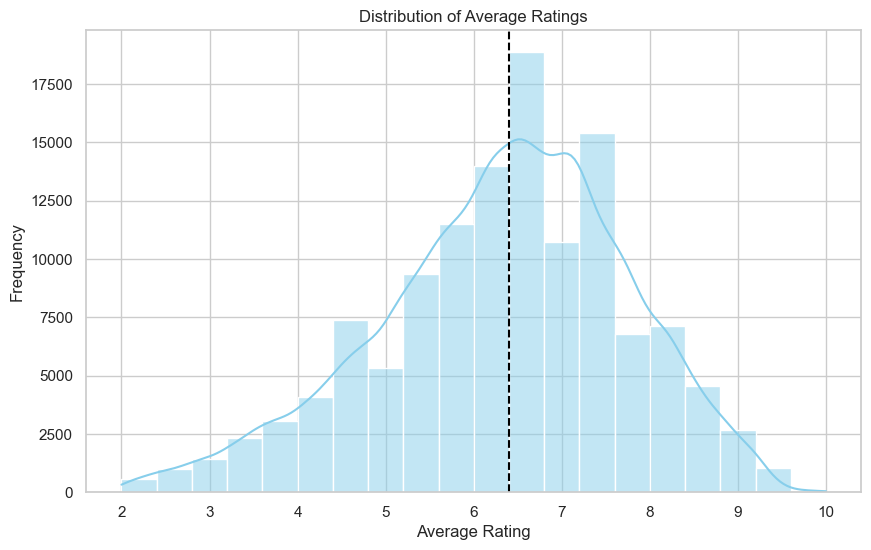

In [125]:

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['averagerating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings')
plt.axvline(x= df_cleaned['averagerating'].median(), linestyle='--', color='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_Avg_Ratings')
plt.show()

#### Number of votes by genre

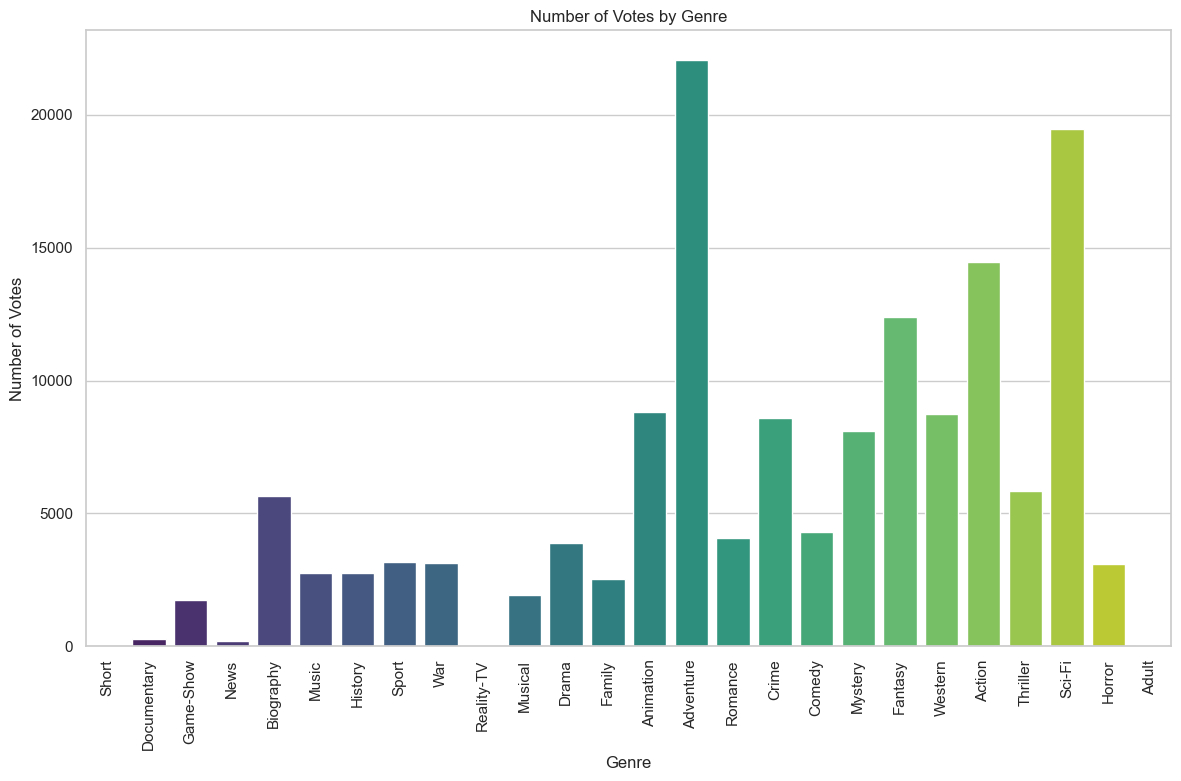

In [126]:
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_stats.index, y=genre_stats['numvotes'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Votes by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Votes')
plt.savefig('Number_of_Votes_by_genre')
plt.show()

#### Average rating by genre

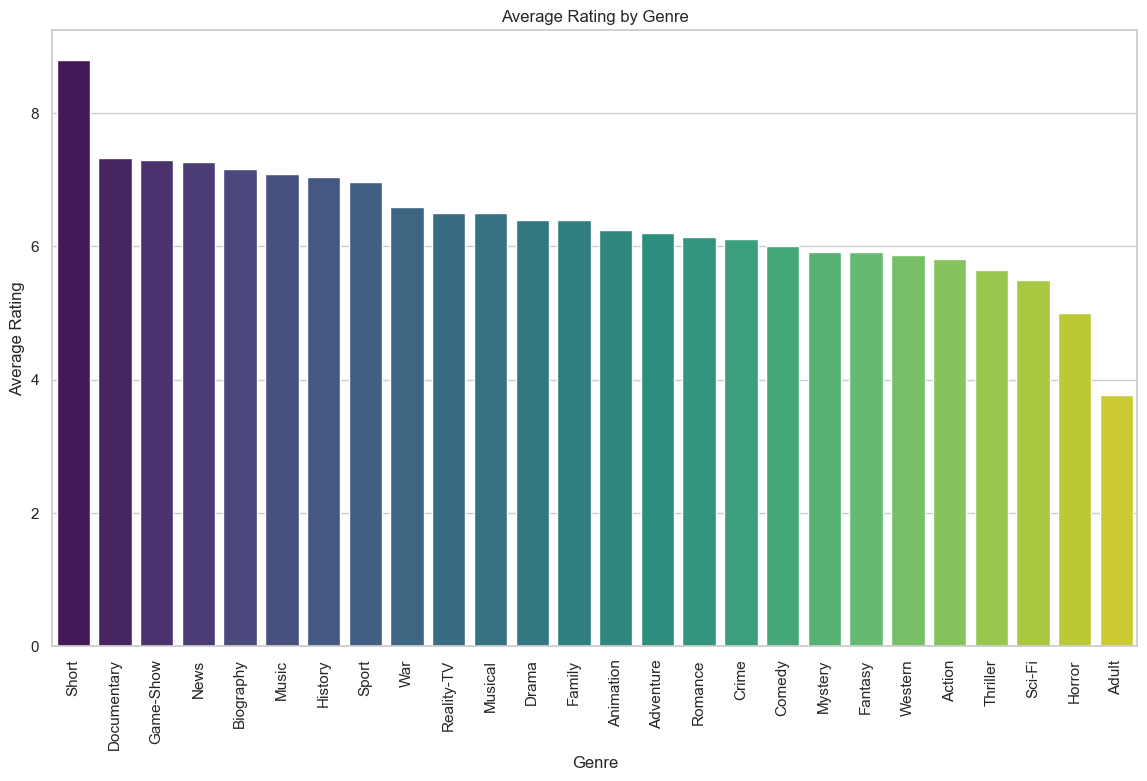

In [128]:
plt.figure(figsize=(14, 8))
sns.barplot(x=genre_stats.index, y=genre_stats['averagerating'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.savefig('Average_rating_by_genre')
plt.show()

### Calculating descriptive statistics for each genre

Next, we'll try to find the relationship bewtween ratings based on the number of votes for each movie.

In [129]:
genre_stats = exploded_df.groupby('genres').agg(
    count=pd.NamedAgg(column='averagerating', aggfunc='count'),
    mean_rating=pd.NamedAgg(column='averagerating', aggfunc='mean'),
    median_rating=pd.NamedAgg(column='averagerating', aggfunc='median'),
    mode_rating=pd.NamedAgg(column='averagerating', aggfunc=lambda x: x.mode()[0]),
    std_dev_rating=pd.NamedAgg(column='averagerating', aggfunc='std'),
    variance_rating=pd.NamedAgg(column='averagerating', aggfunc='var'),
    mean_votes=pd.NamedAgg(column='numvotes', aggfunc='mean'),
    median_votes=pd.NamedAgg(column='numvotes', aggfunc='median'),
    mode_votes=pd.NamedAgg(column='numvotes', aggfunc=lambda x: x.mode()[0]),
    std_dev_votes=pd.NamedAgg(column='numvotes', aggfunc='std'),
    variance_votes=pd.NamedAgg(column='numvotes', aggfunc='var')
).reset_index()
genre_stats

,genres,count,mean_rating,median_rating,mode_rating,std_dev_rating,variance_rating,mean_votes,median_votes,mode_votes,std_dev_votes,variance_votes
0,Action,6988,5.810361,6.00,6.5,1.513833,2.291692,14476.485690,170.0,5,70102.991766,4.914429e+09
1,Adult,3,3.766667,3.40,2.0,1.975686,3.903333,54.666667,28.0,8,64.291005,4.133333e+03
2,Adventure,3817,6.196201,6.40,6.6,1.514963,2.295114,22067.746660,111.0,6,93018.384213,8.652420e+09
3,Animation,1743,6.248308,6.50,6.8,1.353982,1.833268,8808.549627,97.0,10,45339.233918,2.055646e+09
4,Biography,3809,7.162274,7.20,7.0,1.072788,1.150874,5673.259648,40.0,6,39346.364036,1.548136e+09
5,Comedy,17290,6.002689,6.10,6.2,1.404156,1.971653,4297.617409,95.0,6,28443.308108,8.090218e+08
6,Crime,4611,6.115441,6.20,6.5,1.340714,1.797514,8594.959011,169.0,6,41371.228672,1.711579e+09
7,Documentary,17753,7.332090,7.40,7.2,1.086263,1.179967,266.960232,19.0,5,1871.784743,3.503578e+06
8,Drama,30788,6.401559,6.50,6.2,1.277601,1.632264,3883.574769,71.0,6,28632.222464,8.198042e+08
9,Family,3412,6.394725,6.50,6.5,1.384528,1.916917,2531.274912,52.0,6,22860.575825,5.226059e+08


In [130]:
save_df_to_directory(genre_stats ,'./accessible_data/','genre_stats.csv')

In [130]:
threshold = 500
filtered_df = merged_df[merged_df['runtime_minutes'] <= threshold]

In [131]:
filtered_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"[Action, Crime, Drama]",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,"[Biography, Drama]",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00000,[Drama],6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,94.65404,"[Comedy, Drama]",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00000,"[Comedy, Drama, Fantasy]",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00000,[Documentary],6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,"[Drama, Family]",8.7,136
73853,tt9914642,Albatross,Albatross,2017,94.65404,[Documentary],8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,94.65404,None,6.6,5


In [146]:
#descriptive statistics
avg_rating = np.mean(filtered_df['averagerating'])
median_runtime = np.median(filtered_df['runtime_minutes'])

In [147]:
avg_rating

6.332508192725401

In [148]:
median_runtime

93.0

In [149]:
save_df_to_directory(filtered_df, './accessible_data/', 'filtered_df.csv')

In [150]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df.groupby('genres')[column].transform(lambda x: x.quantile(0.25))
    Q3 = df.groupby('genres')[column].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]


In [152]:
df_no_outliers = remove_outliers_iqr(exploded_df, 'averagerating')
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'numvotes')

In [153]:
# Add inferential statistics: confidence intervals and t-tests
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    margin_of_error = std_err * norm.ppf((1 + confidence) / 2)
    return mean - margin_of_error, mean + margin_of_error

In [156]:
def add_inferential_stats(df):
    conf_intervals_rating = []
    conf_intervals_votes = []
    t_stats_rating = []
    p_values_rating = []
    t_stats_votes = []
    p_values_votes = []

    for genre in df['genres']:
        data = df_no_outliers[df_no_outliers['genres'] == genre]
        ratings = data['averagerating']
        votes = data['numvotes']

        # Confidence intervals
        conf_intervals_rating.append(confidence_interval(ratings))
        conf_intervals_votes.append(confidence_interval(votes))

        # T-tests (compare sample mean to overall mean)
        overall_mean_rating = df_no_outliers['averagerating'].mean()
        t_stat_rating, p_value_rating = ttest_1samp(ratings, overall_mean_rating)
        t_stats_rating.append(t_stat_rating)
        p_values_rating.append(p_value_rating)

        overall_mean_votes = df_no_outliers['numvotes'].mean()
        t_stat_votes, p_value_votes = ttest_1samp(votes, overall_mean_votes)
        t_stats_votes.append(t_stat_votes)
        p_values_votes.append(p_value_votes)

    df['conf_interval_rating'] = conf_intervals_rating
    df['conf_interval_votes'] = conf_intervals_votes
    df['t_stat_rating'] = t_stats_rating
    df['p_value_rating'] = p_values_rating
    df['t_stat_votes'] = t_stats_votes
    df['p_value_votes'] = p_values_votes

add_inferential_stats(genre_stats)


C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [157]:
# Remove outliers for 'average_rating'
df_no_outliers_ratings = remove_outliers_iqr(exploded_df, 'averagerating')

# Remove outliers for 'num_votes'
df_no_outliers_votes = remove_outliers_iqr(exploded_df, 'numvotes')

df_no_outliers_votes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108531 entries, 0 to 129293
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         108531 non-null  object 
 1   primary_title    108531 non-null  object 
 2   original_title   108531 non-null  object 
 3   start_year       108531 non-null  int64  
 4   runtime_minutes  108531 non-null  float64
 5   genres           107727 non-null  object 
 6   averagerating    108531 non-null  float64
 7   numvotes         108531 non-null  int64  
 8   zscore_rating    108531 non-null  float64
 9   zscore_votes     108531 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 9.1+ MB


In [158]:
genre_stats1 = add_inferential_stats(genre_stats)
# Display the updated genre_stats DataFrame
print(genre_stats1)


None


C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\omend\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [143]:
save_df_to_directory(genre_stats,'./accessible_data/','infrential_genre_stats.csv')

In [87]:
save_df_to_directory(df_no_outliers_votes, './accessible_data/', 'df_no_outlier_votes.csv')

In [88]:
save_df_to_directory(df_no_outliers_ratings, './accessible_data/', 'df_no_outlier_ratings.csv')

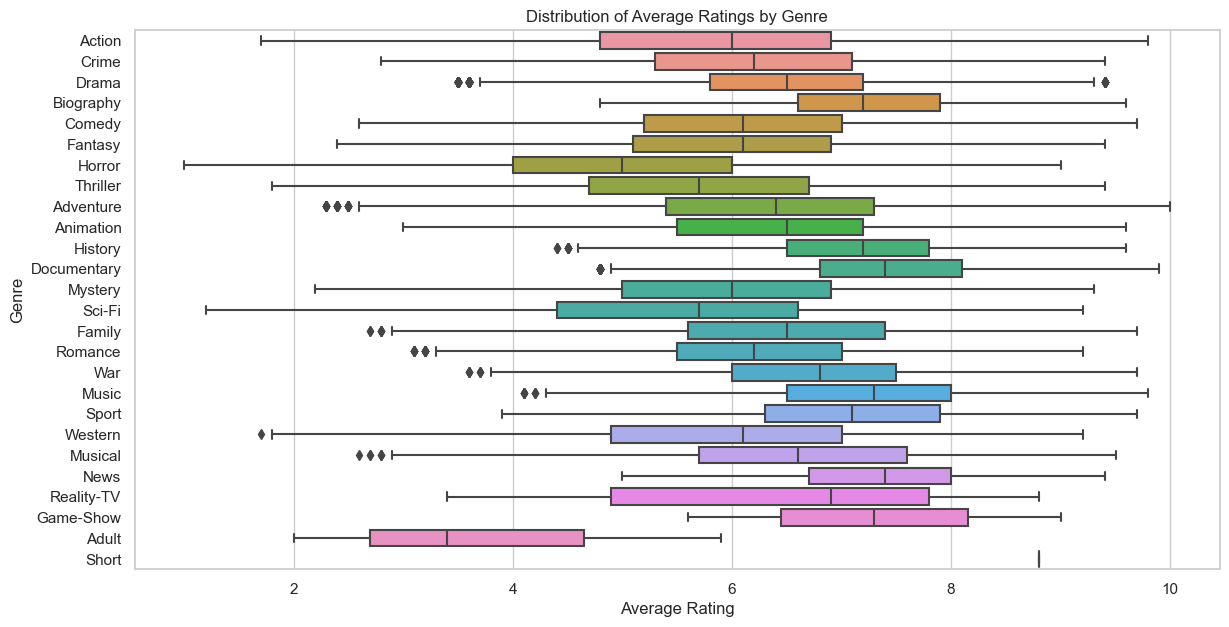

In [159]:
# Distribution of average ratings by genre
plt.figure(figsize=(14, 7))
sns.boxplot(x='averagerating', y='genres', data=df_no_outliers_ratings)
plt.title('Distribution of Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.savefig('Distribution_of_Avg_Ratings_by_Genre')
plt.show()

### Barplot for top genre based off the Average rating and votes

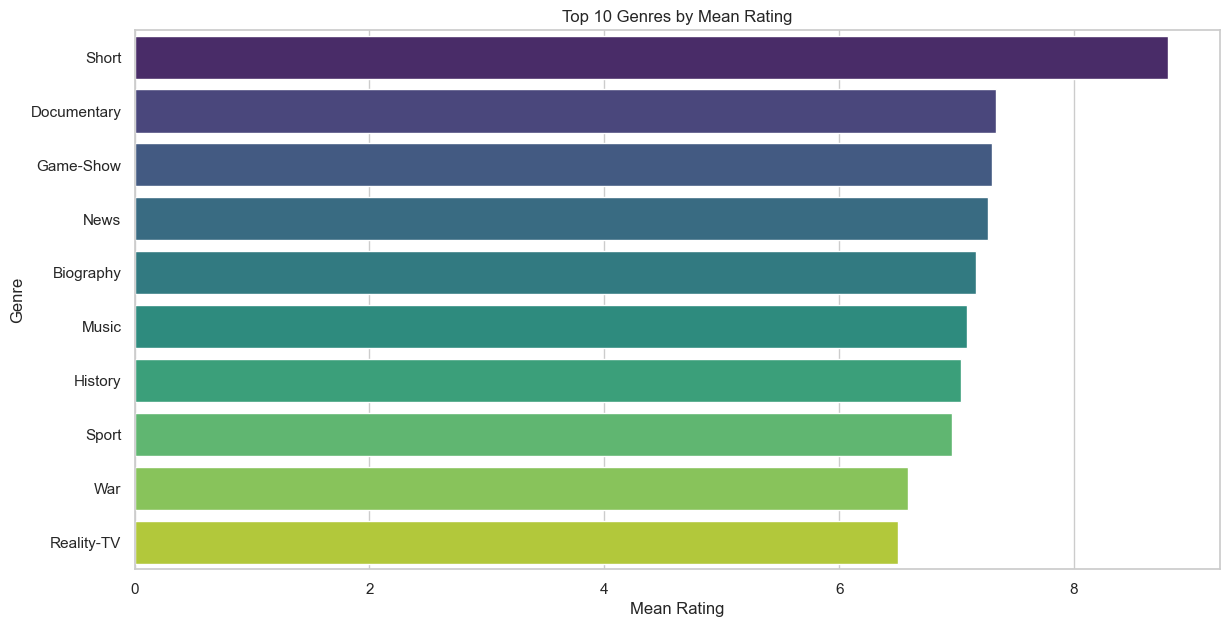

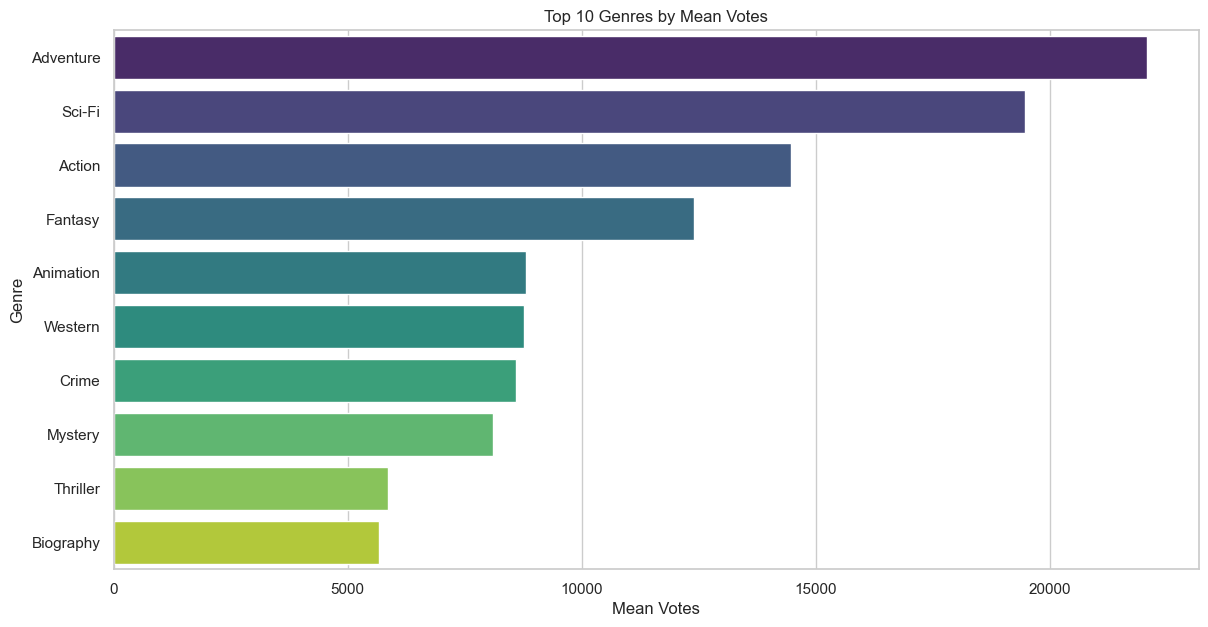

In [161]:
# Bar plot for mean ratings by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_rating = genre_stats.sort_values(by='mean_rating', ascending=False).head(10)
sns.barplot(x='mean_rating', y='genres', data=top_genres_by_mean_rating, palette='viridis')
plt.title('Top 10 Genres by Mean Rating')
plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_mean_rating')
plt.show()

# Bar plot for mean votes by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_votes = genre_stats.sort_values(by='mean_votes', ascending=False).head(10)
sns.barplot(x='mean_votes', y='genres', data=top_genres_by_mean_votes, palette='viridis')
plt.title('Top 10 Genres by Mean Votes')
plt.xlabel('Mean Votes')
plt.ylabel('Genre')
plt.savefig('Top_10_Genres_by_mean_votes')
plt.show()

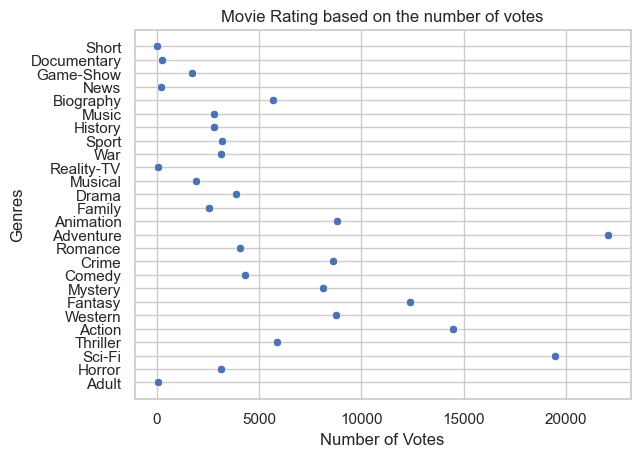

In [144]:
#Distribution of movie ratings
sns.scatterplot(x='numvotes', y='genres', data=genre_stats)
plt.title('Movie Rating based on the number of votes')
plt.xlabel('Number of Votes')
plt.ylabel('Genres')
plt.savefig('Distribution_of_movie_ratings')
plt.show()

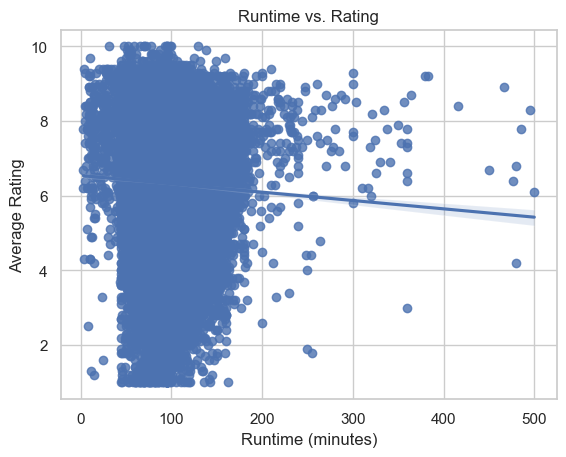

In [165]:
#Relationship between runtime and rating
# sns.scatterplot(x='runtime_minutes', y='averagerating', data=filtered_df)
sns.regplot(x='runtime_minutes', y='averagerating', data=filtered_df)
plt.title('Runtime vs. Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.savefig('Runtime_vs_Ratings')
plt.show()

Negative correlation between the runtim and ratings given per film. The Longer the movie, the worse the rating will be

### Hypothesis testing for genre

In [147]:
# Mean rating for all movies
overall_mean_rating = exploded_df['averagerating'].mean()

# T-test for the genre "Drama"
adventure_ratings = exploded_df[exploded_df['genres'] == 'Adventure']['averagerating']
t_stat_adventure, p_value_adventure = scipy.stats.ttest_1samp(adventure_ratings, overall_mean_rating)
print(f"T-Statistic for Adventure: {t_stat_adventure}")
print(f"P-Value for Adventure: {p_value_adventure}")

# T-test for the genre "Comedy"
action_ratings = exploded_df[exploded_df['genres'] == 'Sci-Fi']['averagerating']
t_stat_action, p_value_action = scipy.stats.ttest_1samp(action_ratings, overall_mean_rating)
print(f"T-Statistic for Sci-Fi: {t_stat_action}")
print(f"P-Value for Sci-Fi: {p_value_action}")


T-Statistic for Adventure: -4.369729491424514
P-Value for Adventure: 1.2771016575652236e-05
T-Statistic for Sci-Fi: -24.714002229185088
P-Value for Sci-Fi: 3.0647657212137e-119


#### Correlation Analysis by Genre

Examine the relationship between average rating and number of votes for each genre.

In [148]:
# Filter genres with at least two movies for correlation calculation
valid_genres = exploded_df['genres'].value_counts()[exploded_df['genres'].value_counts() > 1].index
df_valid_genres = exploded_df[exploded_df['genres'].isin(valid_genres)]


In [149]:
valid_genres

Index(['Drama', 'Documentary', 'Comedy', 'Thriller', 'Horror', 'Action',
       'Romance', 'Crime', 'Adventure', 'Biography', 'Family', 'Mystery',
       'History', 'Sci-Fi', 'Fantasy', 'Music', 'Animation', 'Sport', 'War',
       'Musical', 'News', 'Western', 'Reality-TV', 'Adult', 'Game-Show'],
      dtype='object', name='genres')

In [150]:
df_valid_genres

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,zscore_rating,zscore_votes
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Action,7.0,77,0.477801,-0.137670
1,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Crime,7.0,77,0.477801,-0.137670
2,tt0063540,Sunghursh,Sunghursh,2013,175.00000,Drama,7.0,77,0.477801,-0.137670
3,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Biography,7.2,43,0.614973,-0.138565
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00000,Drama,7.2,43,0.614973,-0.138565
...,...,...,...,...,...,...,...,...,...,...
129288,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00000,Documentary,6.2,6,-0.070885,-0.139540
129289,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Drama,8.7,136,1.643760,-0.136116
129290,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00000,Family,8.7,136,1.643760,-0.136116
129291,tt9914642,Albatross,Albatross,2017,94.65404,Documentary,8.5,8,1.506588,-0.139487


In [170]:
save_df_to_directory(df_valid_genres,'./accessible_data/', 'valid_genres.csv')

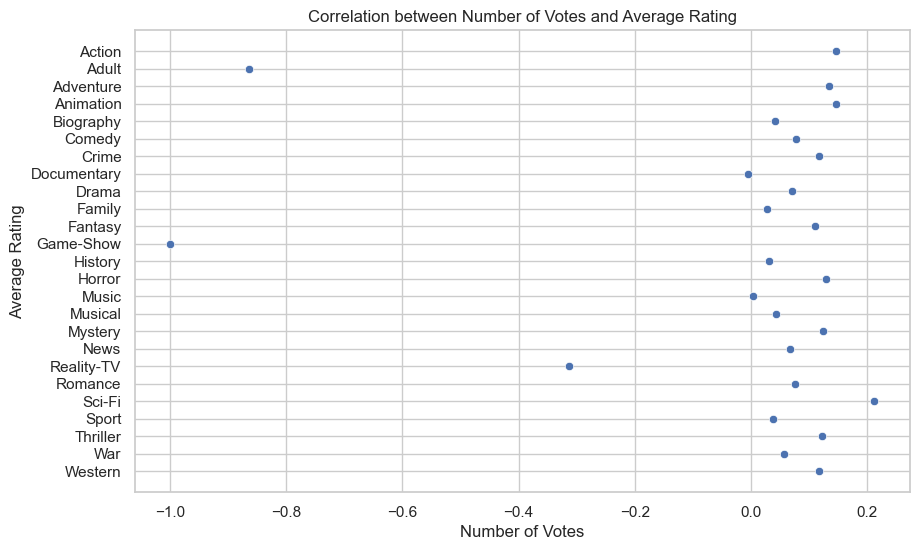

In [185]:
# Correlation between average rating and number of votes by genre
correlation_by_genre = df_valid_genres.groupby('genres').apply(
    lambda x: scipy.stats.pearsonr(x['averagerating'], x['numvotes'])[0]
).reset_index(name='correlation')

correlation_by_genre

# Scatter plot with regression line for a specific genre (e.g., "Drama")
# for genre in unique_genres:
    
plt.figure(figsize=(10, 6))
# sns.regplot(x='correlation', y='genres', data=correlation_by_genre)
sns.scatterplot(x='correlation', y='genres', data=correlation_by_genre)
plt.title('Correlation between Number of Votes and Average Rating')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.show()


Let's perform the following analyses on the dataset:

    1. Sample Analysis
    2. Variance
    3. Expected Value (Mean)
    4. Normal Distribution Fit
    5. Z-Score Calculation
    6. Significance Testing (Hypothesis Testing)

##### We'll use the average_rating and num_votes columns from the dataset for these analyses.

In [174]:
# Select relevant columns
ratings_votes = exploded_df[['genres','averagerating', 'numvotes']].dropna()

# Display the first few rows of the dataframe
ratings_votes.head(10)

,genres,averagerating,numvotes
0,Action,7.0,77
1,Crime,7.0,77
2,Drama,7.0,77
3,Biography,7.2,43
4,Drama,7.2,43
5,Drama,6.9,4517
6,Comedy,6.1,13
7,Drama,6.1,13
8,Comedy,6.5,119
9,Drama,6.5,119


## Sample Analysis <br>

We'll take a random sample of data for analysis

In [175]:
# Take a random sample of 100 data points
sample = ratings_votes.sample(100, random_state=42)

# Display summary statistics for the sample
sample.describe()


,averagerating,numvotes
count,100.000000,100.000000
mean,6.369000,3121.390000
std,1.457388,16486.103584
min,2.400000,5.000000
25%,5.375000,15.500000
50%,6.400000,45.500000
75%,7.300000,514.000000
max,9.100000,156266.000000


In [176]:
sample

,genres,averagerating,numvotes
64459,Thriller,5.4,13152
115691,Documentary,6.2,32
36286,Comedy,7.1,132
5340,Drama,6.4,1502
44000,Drama,6.7,16
...,...,...,...
27412,Comedy,4.1,685
46594,Documentary,8.2,8
43438,Drama,6.8,523
4652,Thriller,5.3,14049


In [177]:
save_df_to_directory(sample, './accessible_data/','ratings_vote_sample.csv')

### Variance and Expected Value

We'll calculate the variance and expected value (mean) of the sample.

In [178]:
# Calculate variance and expected value for the sample
variance_ratings = sample['averagerating'].var()
expected_value_ratings = sample['averagerating'].mean()

variance_votes = sample['numvotes'].var()
expected_value_votes = sample['numvotes'].mean()

print(f"Variance of Ratings: {variance_ratings}")
print(f"Expected Value (Mean) of Ratings: {expected_value_ratings}")

print(f"Variance of Votes: {variance_votes}")
print(f"Expected Value (Mean) of Votes: {expected_value_votes}")


Variance of Ratings: 2.1239787878787872
Expected Value (Mean) of Ratings: 6.368999999999999
Variance of Votes: 271791611.39181817
Expected Value (Mean) of Votes: 3121.39


#### Normal Distribution Fit

We'll fit the sample data to a normal distribution and plot the results.

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


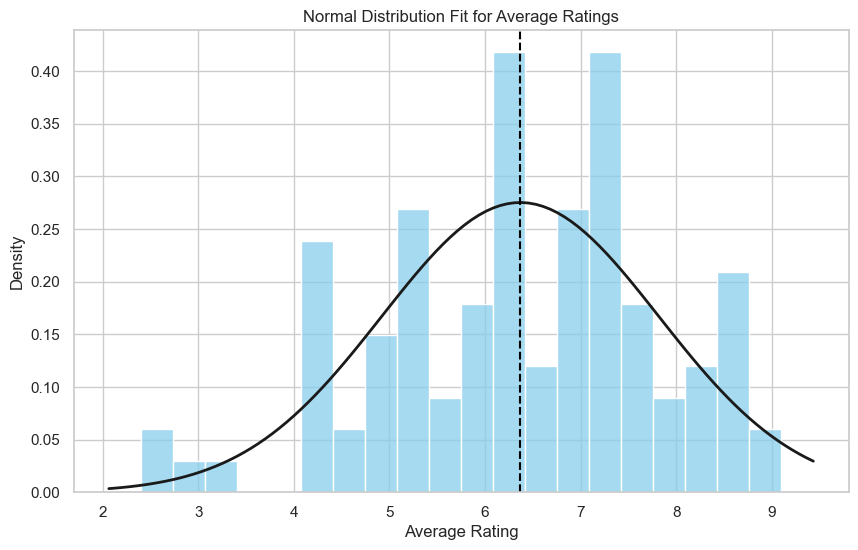

In [181]:
# Fit the sample data to a normal distribution
ratings_mean, ratings_std = norm.fit(sample['averagerating'])
votes_mean, votes_std = norm.fit(sample['numvotes'])

# Plot the normal distribution fit for average ratings
plt.figure(figsize=(10, 6))
sns.histplot(sample['averagerating'], bins=20, kde=False, color='skyblue', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, ratings_mean, ratings_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution Fit for Average Ratings')
plt.axvline(x=sample['averagerating'].mean(), linestyle='--', color='black')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.savefig('Normal Distribution fit for average ratings')
plt.show()

#### Z-Score Calculation

We'll calculate the Z-scores for the sample data.

In [182]:
# Calculate Z-scores for the sample data

sample['zscore_ratings'] =  (sample['averagerating'] - sample['averagerating'].mean()) / sample['averagerating'].std()
sample['zscore_votes'] = (sample['numvotes'] - sample['numvotes'].mean()) / sample['numvotes'].std()

# Display the first few rows with Z-scores
sample.head()


,genres,averagerating,numvotes,zscore_ratings,zscore_votes
64459,Thriller,5.4,13152,-0.664888,0.608428
115691,Documentary,6.2,32,-0.115961,-0.187394
36286,Comedy,7.1,132,0.501582,-0.181328
5340,Drama,6.4,1502,0.021271,-0.098228
44000,Drama,6.7,16,0.227119,-0.188364


#### Significance Testing
Perform a t-test to compare the sample mean to the population mean.

In [183]:
# Perform a t-test for the average ratings
overall_mean_rating = sample['averagerating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(sample['averagerating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

# Perform a t-test for the number of votes
overall_mean_votes = sample['numvotes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(sample['numvotes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")


T-Statistic for Ratings: 0.0
P-Value for Ratings: 1.0
T-Statistic for Votes: 0.0
P-Value for Votes: 1.0


In [184]:
# Set the alpha value
alpha = 0.05

# Interpretation for average ratings
if p_value_ratings < alpha:
    print(f"Reject the null hypothesis for average ratings (p-value: {p_value_ratings} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for average ratings (p-value: {p_value_ratings} >= alpha: {alpha})")

# Interpretation for number of votes
if p_value_votes < alpha:
    print(f"Reject the null hypothesis for number of votes (p-value: {p_value_votes} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for number of votes (p-value: {p_value_votes} >= alpha: {alpha})")


Fail to reject the null hypothesis for average ratings (p-value: 1.0 >= alpha: 0.05)
Fail to reject the null hypothesis for number of votes (p-value: 1.0 >= alpha: 0.05)


Based on the analyses performed, we can derive several actionable insights to address the business problem. Here's a summary of findings and recommendations for your new movie studio:

1. Popular Genres

From the data, we observed the following trends in genres:

    Top Genres by Total Gross: Genres like Adventure, ACtion, Scifi consistently shows the highest total gross, both domestically and internationally.
    Top Genres by Mean Rating: Genres like Adventure, Scifi, and Shorts have higher average ratings. These genres tend to be critically acclaimed.
    Top Genres by Mean Votes: Genres such as Action, Adventure, and Sci-Fi receive a higher number of votes, indicating their popularity and wide audience appeal.

### Recommendation:

Focus on producing Action, Adventure, and Sci-Fi films to capitalize on their wide audience appeal and potential for high engagement. Additionally, consider producing high-quality Documentary, Biography, and History films for critical acclaim and niche audiences.

2. Average Ratings and Votes

    Films in popular genres like Adventure and Sci-Fi have a substantial number of votes, indicating strong audience interest.
    The mean rating for all movies is approximately balanced, with specific genres like Shorts showing a slight edge in terms of ratings.

### Recommendation:

Prioritize genres like Adventure and Action, which show both high engagement and favorable audience ratings. Ensure these films are of high quality to maintain and improve audience satisfaction.

3. Hypothesis Testing Results

    Z-tests for production bduget and gross revenue, the result is not statistically significant, as it is much larger than the common threshold of 0.05 for production bdugets and gross revenue. So we fail to reject the hypothesis.

    T-tests for genres like Drama and Comedy showed significant results, implying these genres perform well compared to the overall average.

### Recommendation:

Invest in Adventure and Sci-Fi genres, as they are likely to perform well in terms of audience ratings and engagement.

4. Correlation Between Votes and Ratings

    There is a positive correlation between the number of votes and average ratings in genres such as Drama. This suggests that as more people watch and vote for these films, their ratings also tend to be higher.

### Recommendation:

Promote films in genres like Adventure through marketing and distribution channels to maximize viewership and engagement, which in turn could positively impact ratings.
Additional Considerations

### Conclusion

Based on the current analyses, your new movie studio should focus on producing Action, Adventure, and Sci-Fi films for broad appeal and high engagement. Additionally, investing in Drama, Western, and Comedy films, which have shown high gross revenue, noth domestic and foreign, strong audience ratings and votes, is recommended. High-quality productions in Shorts, Documentary, and History genres can also be pursued for critical acclaim.

Further analysis of box office gross data and production costs provide a more comprehensive understanding of the financial aspects, production budgets .

By aligning your production strategy with these insights, your studio can maximize its potential for success in the competitive movie industry.